# 高通量多肽筛选与生成（结构引导 + TARSA 思路）

目标：基于 6P8E/6P8F/6P8G（C 链为参考 PPI 抑制多肽）构建一个**可解释、可重复**的多肽筛选与生成流水线：

1. 训练 5 个序列判别模型：
   - 螺旋结构倾向（PDBlarge.csv）
   - 肿瘤靶向潜力（TumorHoPe.fasta）
   - 穿膜能力（CPPsite 2.0.fasta）
   - 抗肿瘤潜力（CancerPPD.fasta）
   - 临床开发潜力（THPdb.fasta）
2. 从 3 个复合物结构中提取结合口袋/相互作用，构建**界面偏好 profile**（可解释）。
3. 以短肽为起点，通过 beam-search/贪婪式分支迭代延伸（≤15 肽），亲和力不提升即停止。
4. 对候选肽用 5 个模型评估，保留同时满足全部潜力的高亲和力多肽。
5. 对最终前 10 条用 ESMFold 对 A/B 链 + 多肽进行复合物建模（优先使用 fair-esm，支持多链）。

参考：Pandey et al., *Nat. Commun.* (2025) — TARSA（RL + posterior sampling）用于超大肽库筛选。


In [1]:
import importlib


def _safe_version(import_name: str) -> str:
    try:
        m = importlib.import_module(import_name)
        return str(getattr(m, "__version__", "unknown"))
    except Exception:
        return "not_installed"


required = {
    "numpy": "numpy",
    "pandas": "pandas",
    "sklearn": "scikit-learn",
    "Bio": "biopython",
    "yaml": "pyyaml",
    "tqdm": "tqdm",
    "joblib": "joblib",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "torch": "torch",
    "transformers": "transformers",
}
optional = {
    "esm": "fair-esm",
    "py3Dmol": "py3Dmol",
    "networkx": "networkx",
    "plotly": "plotly",
    "umap": "umap-learn",
    "shap": "shap",
}

missing = []
print("Required packages:")
for import_name, pkg_name in required.items():
    v = _safe_version(import_name)
    print(f"  - {pkg_name:16s} (import {import_name}) : {v}")
    if v == "not_installed":
        missing.append(pkg_name)

print()
print("Optional packages:")
for import_name, pkg_name in optional.items():
    v = _safe_version(import_name)
    print(f"  - {pkg_name:16s} (import {import_name}) : {v}")

if missing:
    raise RuntimeError(
        "Missing required packages: "
        + ", ".join(sorted(set(missing)))
        + ". Install with: pip install -r requirements.txt"
    )


Required packages:
  - numpy            (import numpy) : 1.26.4
  - pandas           (import pandas) : 2.3.3
  - scikit-learn     (import sklearn) : 1.7.2
  - biopython        (import Bio) : 1.79
  - pyyaml           (import yaml) : 6.0.3
  - tqdm             (import tqdm) : 4.67.1
  - joblib           (import joblib) : 1.5.3
  - matplotlib       (import matplotlib) : 3.9.2
  - seaborn          (import seaborn) : 0.12.2
  - torch            (import torch) : 2.5.1+cu121
  - transformers     (import transformers) : 4.57.3

Optional packages:
  - fair-esm         (import esm) : 2.0.0
  - py3Dmol          (import py3Dmol) : 2.5.3
  - networkx         (import networkx) : 3.4.2
  - plotly           (import plotly) : not_installed
  - umap-learn       (import umap) : not_installed
  - shap             (import shap) : not_installed


In [2]:
import os
from pathlib import Path

# 统一把工作目录切到项目根目录，确保 configs/default.yaml 中的相对路径都可用
here = Path.cwd()
candidates = [here, here.parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / 'configs' / 'default.yaml').exists() and (c / '6P8E.pdb').exists():
        PROJECT_ROOT = c
        break
if PROJECT_ROOT is None:
    raise RuntimeError('无法定位项目根目录：请在 notebooks/ 下运行，或手动 os.chdir(...)')
os.chdir(PROJECT_ROOT)
print('CWD =', Path.cwd())


CWD = /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/Food Chemistry


In [3]:
from datetime import datetime
from pathlib import Path
import logging
import platform
import sys

from peptide_screening.config import load_config
from peptide_screening.utils import seed_everything, setup_logging, get_logger
from peptide_screening.viz import set_publication_style, savefig

set_publication_style()
cfg = load_config('configs/default.yaml').raw
seed_everything(int(cfg['run']['random_seed']))

run_id = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = Path(cfg['run']['out_dir']) / run_id
fig_dir = Path(cfg['run']['figure_dir']) / run_id
run_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

setup_logging(log_path=run_dir / 'run.log', level=logging.INFO)
logger = get_logger()
logger.info('run_id=%s', run_id)
logger.info('python=%s', sys.version.split()[0])
logger.info('platform=%s', platform.platform())
try:
    import torch

    logger.info('torch=%s cuda=%s', torch.__version__, torch.cuda.is_available())
    if torch.cuda.is_available():
        logger.info('gpu=%s', torch.cuda.get_device_name(0))
except Exception as e:
    logger.warning('torch info unavailable: %s', e)

print('run_dir =', run_dir)
print('fig_dir =', fig_dir)


2026-01-01 00:24:17,880 | INFO | run_id=20260101_002417
2026-01-01 00:24:17,880 | INFO | python=3.10.19
2026-01-01 00:24:17,880 | INFO | platform=Linux-6.8.0-90-generic-x86_64-with-glibc2.35
2026-01-01 00:24:17,886 | INFO | torch=2.5.1+cu121 cuda=True
2026-01-01 00:24:17,897 | INFO | gpu=NVIDIA GeForce RTX 4080


run_dir = results/20260101_002417
fig_dir = figures/20260101_002417


In [4]:
import copy

# QUICK_MODE controls subsampling for fast iteration; disable it for full-scale runs.
QUICK_MODE = False

if QUICK_MODE:
    cfg = copy.deepcopy(cfg)
    cfg["training"]["helix"]["pos_sample_n"] = 50000
    cfg["training"]["helix"]["neg_sample_n"] = 50000

print("QUICK_MODE =", QUICK_MODE)
print("helix pos/neg =", cfg["training"]["helix"]["pos_sample_n"], cfg["training"]["helix"]["neg_sample_n"])


QUICK_MODE = False
helix pos/neg = 200000 200000


## 0) Workflow overview（流程总览图）


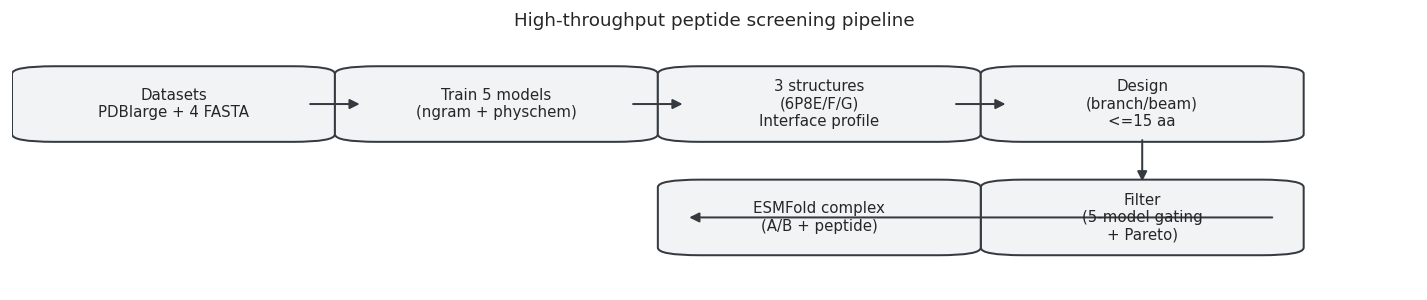

In [5]:
import matplotlib.pyplot as plt
from peptide_screening.viz import plot_project_framework, savefig

fig = plot_project_framework(
    title='高通量多肽筛选与生成：项目流程框架图（结构引导 + TARSA 思路）'
)
savefig(fig, fig_dir / 'workflow_overview.png')
plt.show()


## 1) 数据读取与 QC（长度分布等）


/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

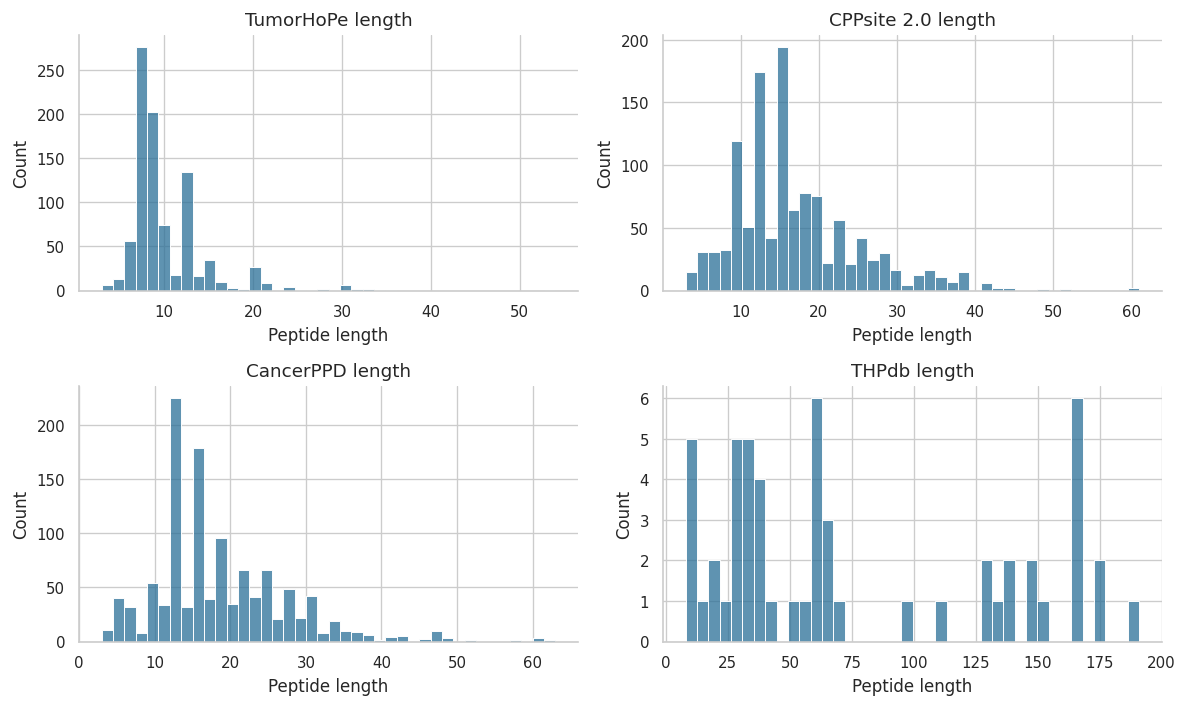

In [6]:
from peptide_screening.data import read_fasta_sequences
from peptide_screening.viz import plot_length_distribution, savefig
import matplotlib.pyplot as plt

tumor = read_fasta_sequences(cfg['paths']['datasets']['tumorhope_fasta'], min_len=3, max_len=80)
cpp = read_fasta_sequences(cfg['paths']['datasets']['cppsite_fasta'], min_len=3, max_len=80)
anti = read_fasta_sequences(cfg['paths']['datasets']['cancerppd_fasta'], min_len=3, max_len=80)
clin = read_fasta_sequences(cfg['paths']['datasets']['thpdb_fasta'], min_len=3, max_len=200)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plot_length_distribution(tumor, title='TumorHoPe length', ax=axes[0,0])
plot_length_distribution(cpp, title='CPPsite 2.0 length', ax=axes[0,1])
plot_length_distribution(anti, title='CancerPPD length', ax=axes[1,0])
plot_length_distribution(clin, title='THPdb length', ax=axes[1,1])
savefig(fig, fig_dir / 'dataset_length_distributions.png')
plt.show()


### 1.1 氨基酸组成（热图）


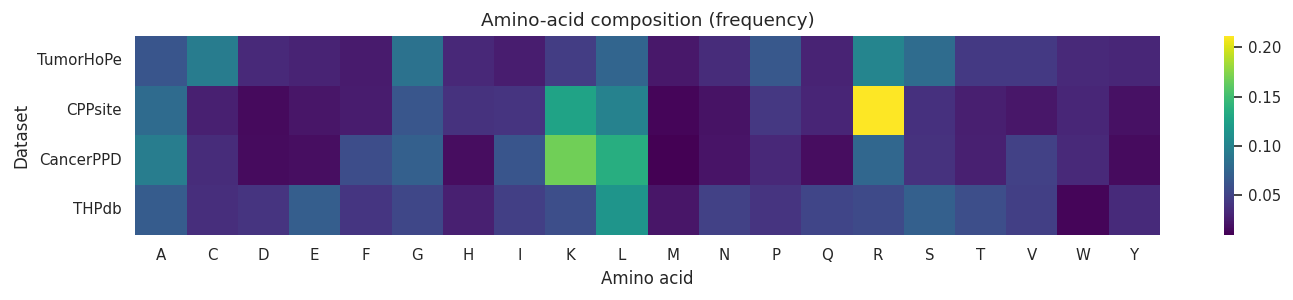

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from peptide_screening.data import STANDARD_AA

datasets = {
    'TumorHoPe': tumor,
    'CPPsite': cpp,
    'CancerPPD': anti,
    'THPdb': clin,
}

def aa_composition(seqs):
    counts = {aa: 0 for aa in STANDARD_AA}
    total = 0
    for s in seqs:
        for ch in s:
            if ch in counts:
                counts[ch] += 1
                total += 1
    total = max(total, 1)
    return pd.Series({aa: counts[aa] / total for aa in STANDARD_AA})

comp = pd.DataFrame({name: aa_composition(seqs) for name, seqs in datasets.items()}).T

fig, ax = plt.subplots(figsize=(12, 2.6))
sns.heatmap(comp, cmap='viridis', ax=ax)
ax.set_title('Amino-acid composition (frequency)')
ax.set_xlabel('Amino acid')
ax.set_ylabel('Dataset')
savefig(fig, fig_dir / 'aa_composition_heatmap.png')
plt.show()


### 1.2 物化特征空间（电荷 vs 疏水性）


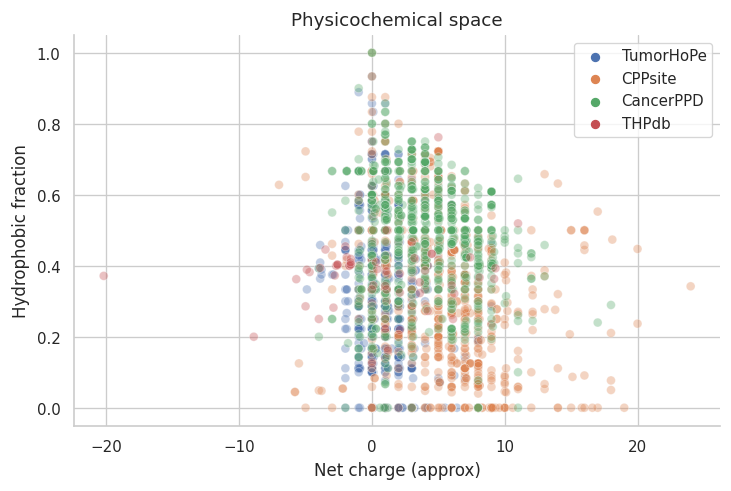

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from peptide_screening.features import compute_physchem_features

rng = np.random.default_rng(int(cfg['run']['random_seed']))
frames = []
for name, seqs in datasets.items():
    if len(seqs) == 0:
        continue
    take = min(800, len(seqs))
    idx = rng.choice(len(seqs), size=take, replace=False)
    sample = [seqs[i] for i in idx.tolist()]
    df = compute_physchem_features(sample)
    df['dataset'] = name
    frames.append(df)

df_props = pd.concat(frames, ignore_index=True)

fig, ax = plt.subplots(figsize=(6.2, 4.2))
sns.scatterplot(
    data=df_props,
    x='net_charge_approx',
    y='hydrophobic_frac',
    hue='dataset',
    alpha=0.35,
    s=28,
    ax=ax,
)
ax.set_title('Physicochemical space')
ax.set_xlabel('Net charge (approx)')
ax.set_ylabel('Hydrophobic fraction')
ax.legend(title='', frameon=True, loc='best')
savefig(fig, fig_dir / 'physchem_space_scatter.png')
plt.show()


## 2) 训练 5 个序列判别模型（可重复 + 可解释）

说明：
- 主要模型：字符 n-gram + 线性分类器（可扩展到大规模数据，并支持基于 k-mer/motif 的解释）
- 辅助模型：物化特征 + GBDT（支持 feature importance / SHAP）
- 集成策略：基于验证集 AUC 估计权重，用于抑制低信号模型对集成的影响
- 负样本：采用 shuffle/random/mix 构造 decoy；因此评估指标刻画的是“阳性 vs decoy”的可分性


In [9]:
from peptide_screening.pipeline import train_or_load_models
import joblib

model_dir = run_dir / 'models'
models = train_or_load_models(cfg, model_dir=model_dir)
print('trained/loaded models:', list(models))

# 训练报告（AUC 等）
report_path = model_dir / 'training_report.joblib'
if report_path.exists():
    report = joblib.load(report_path)
    report


2026-01-01 00:24:19,825 | INFO | Training models (not found in results/20260101_002417/models)
2026-01-01 00:24:19,825 | INFO | Training start | out_dir=results/20260101_002417/models
2026-01-01 00:24:19,825 | INFO | Sampling from CSV | file=PDBlarge.csv column=Peptide target_n=200000 chunksize=200000


Sampling Peptide from PDBlarge.csv: 0chunk [00:00, ?chunk/s]

2026-01-01 00:24:22,793 | INFO | Sampling done | sampled=200000 seen_valid=1048575 file=PDBlarge.csv
2026-01-01 00:24:22,793 | INFO | helix positives sampled: 200000
2026-01-01 00:24:24,978 | INFO | helix dataset built: n=400000 (pos=200000 neg=200000)


tumor_targeting: shuffled negatives:   0%|          | 0/895 [00:00<?, ?pep/s]

2026-01-01 00:24:24,998 | INFO | tumor_targeting dataset built: n=2685 (pos=895 neg=1790)


cpp: shuffled negatives:   0%|          | 0/1167 [00:00<?, ?pep/s]

2026-01-01 00:24:25,028 | INFO | cpp dataset built: n=3501 (pos=1167 neg=2334)


anti_tumor: shuffled negatives:   0%|          | 0/1134 [00:00<?, ?pep/s]

2026-01-01 00:24:25,063 | INFO | anti_tumor dataset built: n=3402 (pos=1134 neg=2268)


clinical_dev: shuffled negatives:   0%|          | 0/68 [00:00<?, ?pep/s]

2026-01-01 00:24:25,075 | INFO | clinical_dev dataset built: n=158 (pos=45 neg=113)


Training sequence models:   0%|          | 0/5 [00:00<?, ?task/s]

2026-01-01 00:24:37,137 | INFO | Trained helix           | roc_auc=0.909 pr_auc=0.908 n_test=80000 weights={'ngram': 0.399764265625, 'physchem': 0.40895217562499986}
2026-01-01 00:24:37,812 | INFO | Trained tumor_targeting | roc_auc=0.706 pr_auc=0.615 n_test=537 weights={'ngram': 0.20598608033457122, 'physchem': 0.0}
2026-01-01 00:24:38,470 | INFO | Trained cpp             | roc_auc=0.890 pr_auc=0.853 n_test=701 weights={'ngram': 0.3970241036622194, 'physchem': 0.018430059115283948}
2026-01-01 00:24:39,004 | INFO | Trained anti_tumor      | roc_auc=0.918 pr_auc=0.892 n_test=681 weights={'ngram': 0.4198218478914786, 'physchem': 0.005045702419996467}
2026-01-01 00:24:39,338 | INFO | Trained clinical_dev    | roc_auc=0.758 pr_auc=0.603 n_test=32 weights={'ngram': 0.2584541062801933, 'physchem': 0.0}
2026-01-01 00:24:39,340 | INFO | Training done | saved models=5


trained/loaded models: ['helix', 'tumor_targeting', 'cpp', 'anti_tumor', 'clinical_dev']


### 2.1 模型评估曲线（ROC/PR + 校准 + 混淆矩阵）


Evaluating models:   0%|          | 0/5 [00:00<?, ?task/s]

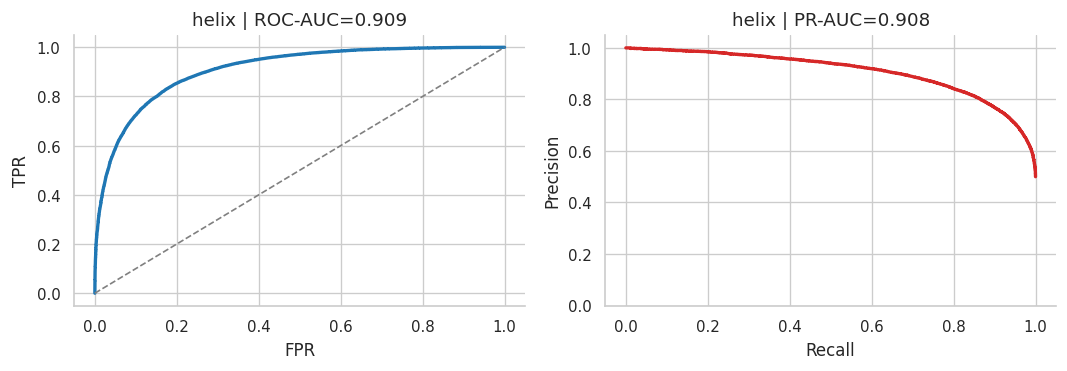

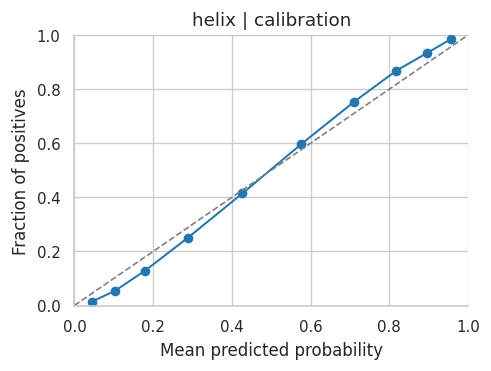

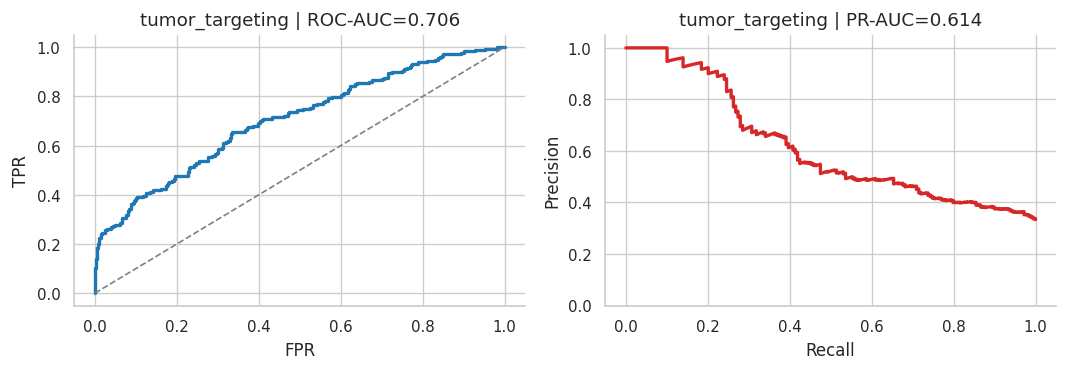

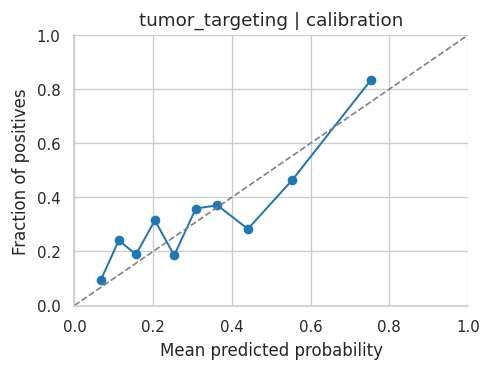

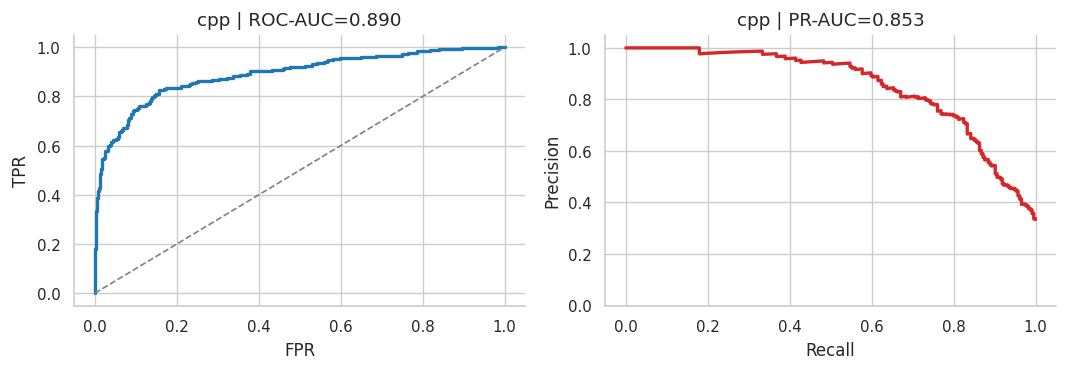

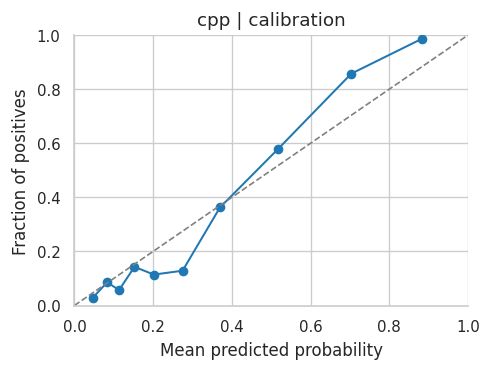

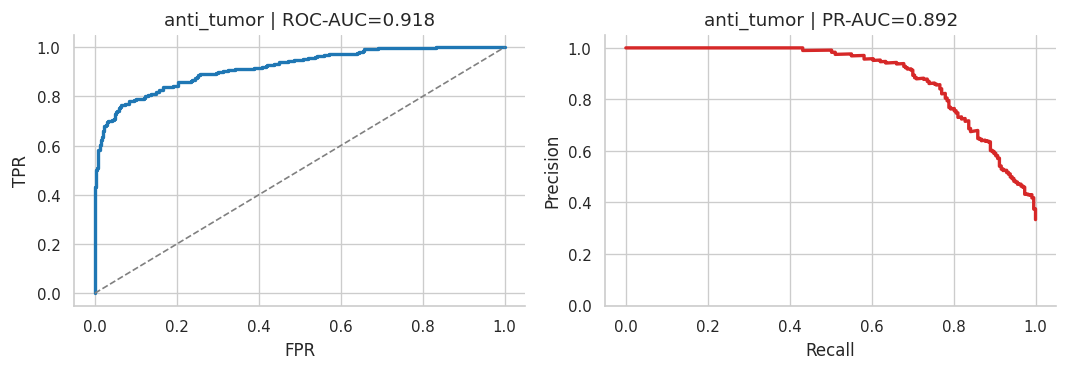

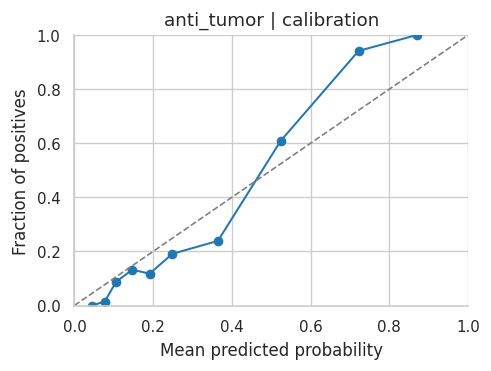

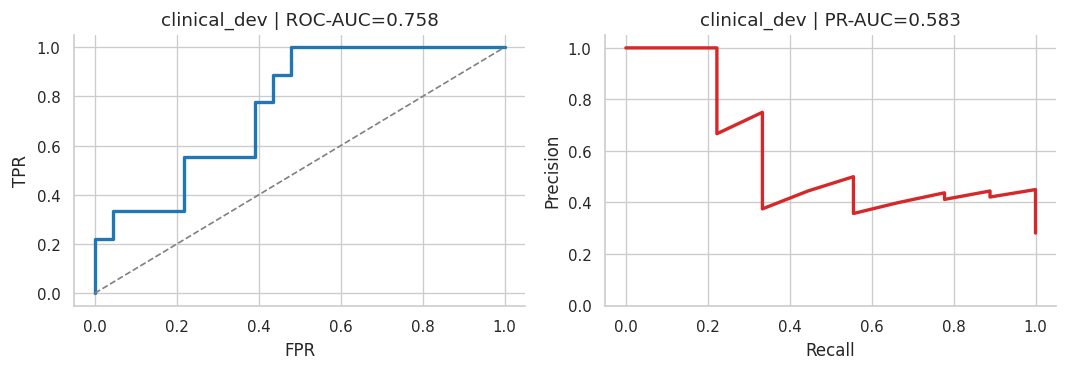

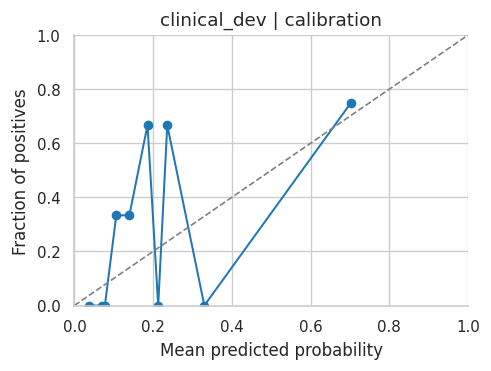

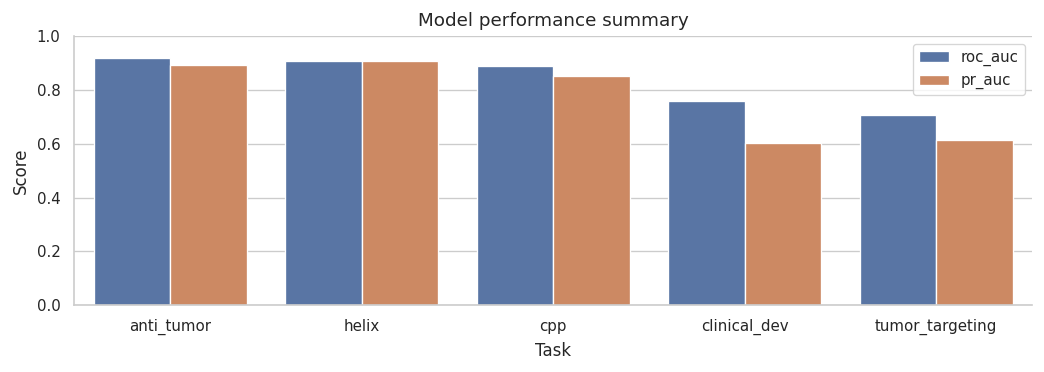

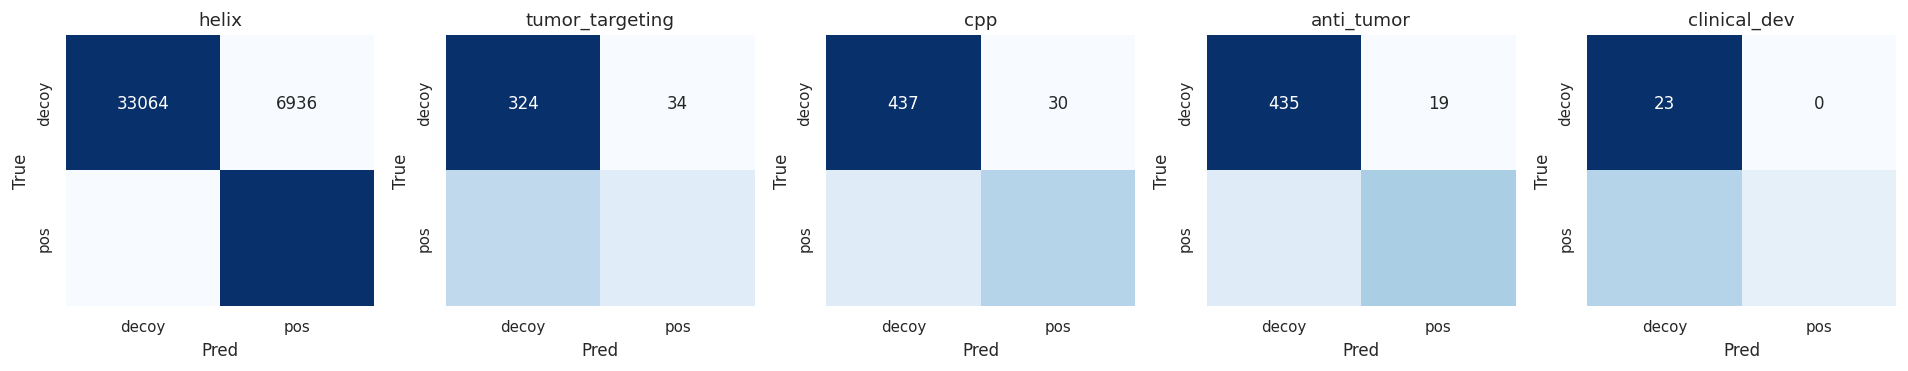

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

from peptide_screening.viz import plot_roc_pr, plot_calibration, savefig

# 直接使用训练阶段保存的 eval（避免重复重采样 PDBlarge）
if 'report' not in globals() or report is None:
    import joblib

    report = joblib.load(model_dir / 'training_report.joblib')

rows = []
conf_mats = {}

# 用 tqdm 展示进度（虽然任务数不多，但保持一致）
from tqdm.auto import tqdm

for name in tqdm(report.keys(), desc='Evaluating models', unit='task'):
    eval_data = report[name].get('eval', {})
    y_true = np.asarray(eval_data.get('y_true', []), dtype=int)
    y_prob = np.asarray(eval_data.get('y_prob', []), dtype=float)
    if y_true.size == 0 or y_prob.size == 0:
        print(f'WARN: missing eval data for {name}, skip plots')
        continue

    rows.append({
        'task': name,
        'n_test': int(len(y_true)),
        'roc_auc': float(roc_auc_score(y_true, y_prob)),
        'pr_auc': float(average_precision_score(y_true, y_prob)),
    })

    fig = plot_roc_pr(y_true, y_prob, title=f'{name}')
    savefig(fig, fig_dir / f'roc_pr_{name}.png')
    plt.show()

    fig = plot_calibration(y_true, y_prob, title=f'{name}', n_bins=10)
    savefig(fig, fig_dir / f'calibration_{name}.png')
    plt.show()

    y_pred = (y_prob >= 0.5).astype(int)
    conf_mats[name] = confusion_matrix(y_true, y_pred, labels=[0, 1])

summary = pd.DataFrame(rows).sort_values('roc_auc', ascending=False)
summary

# summary barplot
fig, ax = plt.subplots(figsize=(8.8, 3.2))
df_long = summary.melt(id_vars=['task', 'n_test'], value_vars=['roc_auc', 'pr_auc'], var_name='metric', value_name='value')
sns.barplot(data=df_long, x='task', y='value', hue='metric', ax=ax)
ax.set_title('Model performance summary')
ax.set_xlabel('Task')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.0)
ax.legend(title='')
savefig(fig, fig_dir / 'model_performance_summary.png')
plt.show()

# confusion matrices grid
fig, axes = plt.subplots(1, len(conf_mats), figsize=(3.2 * len(conf_mats), 3.2))
if len(conf_mats) == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, conf_mats.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Pred')
    ax.set_ylabel('True')
    ax.set_xticklabels(['decoy', 'pos'])
    ax.set_yticklabels(['decoy', 'pos'])
savefig(fig, fig_dir / 'confusion_matrices.png')
plt.show()


### 2.2 可解释 motif：k-mer 富集（log-odds）


2026-01-01 00:24:43,085 | INFO | Sampling from CSV | file=PDBlarge.csv column=Peptide target_n=20000 chunksize=200000


Sampling Peptide from PDBlarge.csv: 0chunk [00:00, ?chunk/s]

2026-01-01 00:24:46,161 | INFO | Sampling done | sampled=20000 seen_valid=1048575 file=PDBlarge.csv


Motif plots:   0%|          | 0/5 [00:00<?, ?task/s]

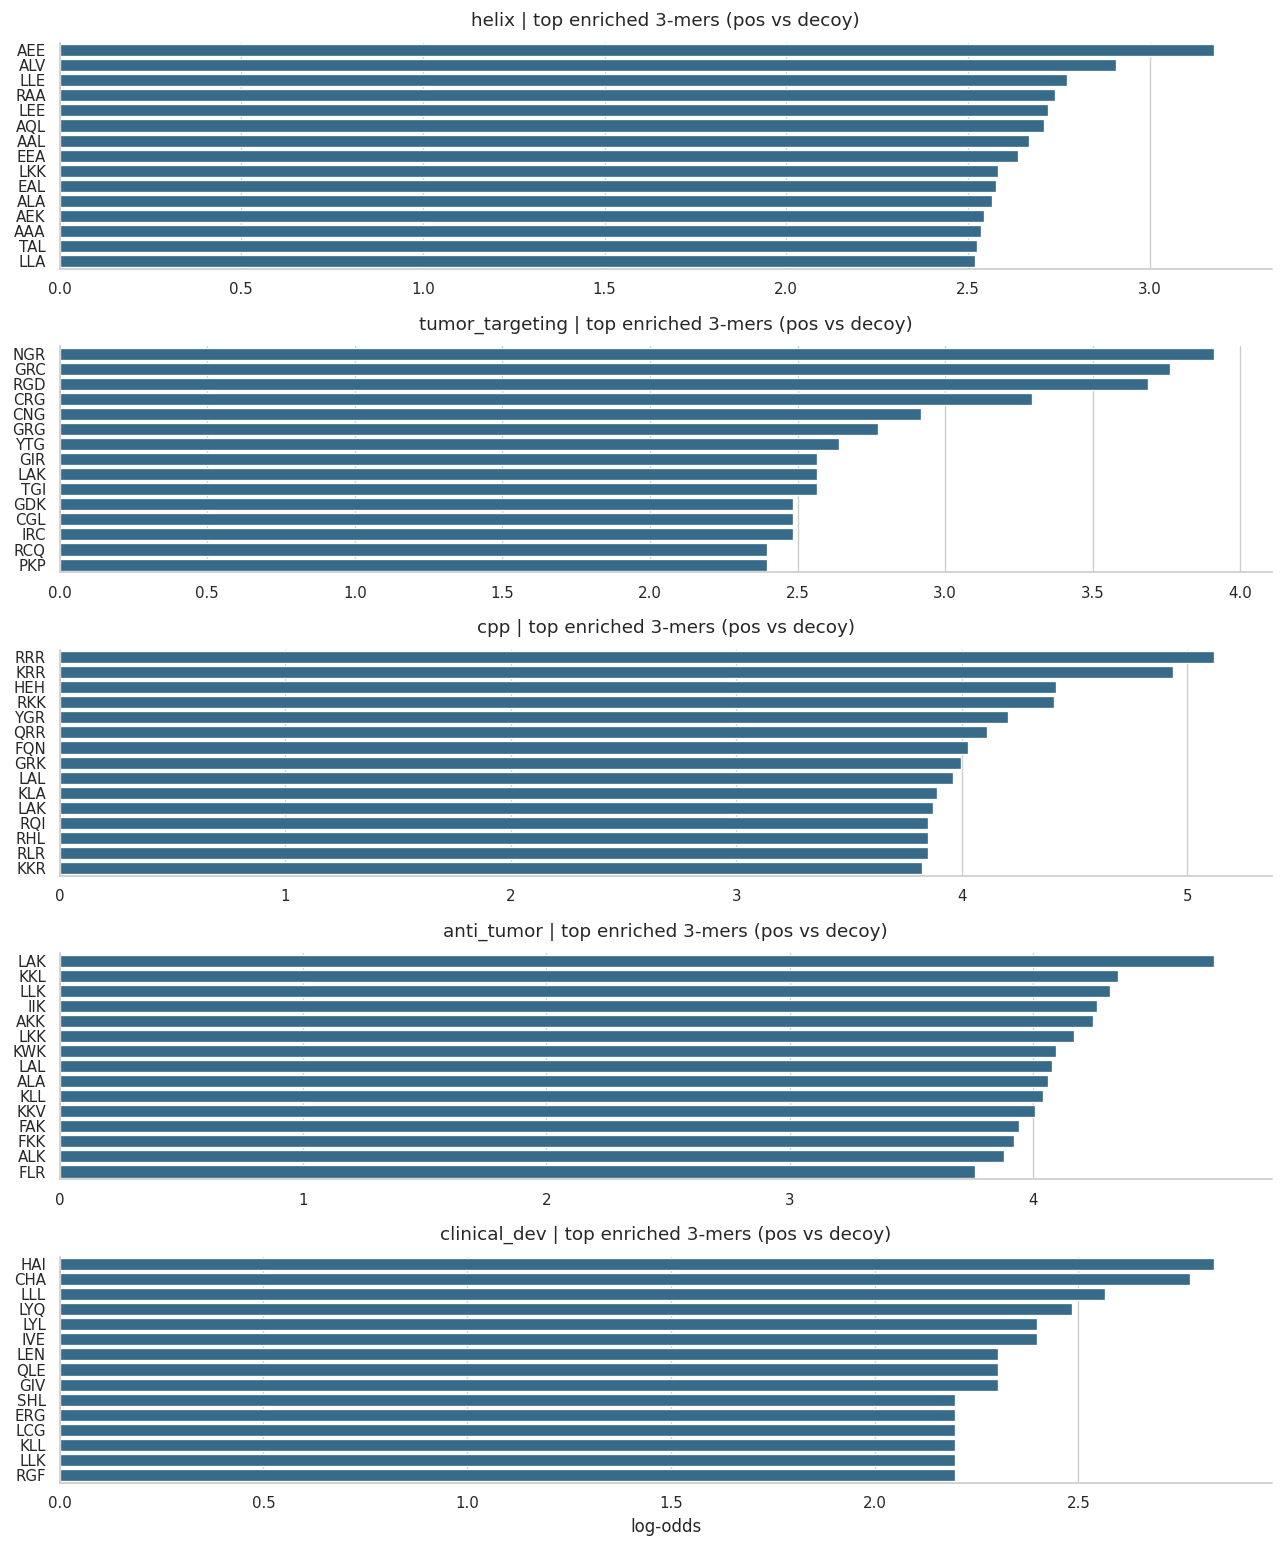

In [11]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from peptide_screening.data import STANDARD_AA, make_random_negatives, reservoir_sample_csv_column


def kmer_counts(seqs, k):
    c = Counter()
    for s in seqs:
        if len(s) < k:
            continue
        for i in range(len(s) - k + 1):
            c[s[i:i+k]] += 1
    return c


def top_kmer_logodds(pos, neg, k=3, top_n=15, alpha=1.0):
    cp = kmer_counts(pos, k)
    cn = kmer_counts(neg, k)
    keys = set(cp) | set(cn)
    rows = []
    for km in keys:
        p = cp.get(km, 0) + alpha
        n = cn.get(km, 0) + alpha
        rows.append((km, float(np.log(p / n))))
    df = pd.DataFrame(rows, columns=['kmer', 'log_odds']).sort_values('log_odds', ascending=False)
    return df.head(top_n)


# 为了避免重复进行大规模采样，这里用于“可解释 motif 图”的数据集采用：
# - tumor/cpp/anti/clinical：直接用 FASTA 正样本 + 随机负样本
# - helix：从 PDBlarge 抽样较小子集 + 随机负样本
rng = np.random.default_rng(int(cfg['run']['random_seed']))

# helix motif sample（控制规模，确保可快速出图；需要更严格可与训练保持一致）
helix_pos_n = int(min(20000, cfg['training']['helix']['pos_sample_n'] // 5))
helix_pos = reservoir_sample_csv_column(
    cfg['paths']['pdblarge_csv'],
    column='Peptide',
    n=helix_pos_n,
    seed=int(cfg['run']['random_seed']),
    min_len=int(cfg['training']['helix']['min_len']),
    max_len=int(cfg['training']['helix']['max_len']),
    show_progress=True,
)
helix_neg = make_random_negatives(
    lengths=[len(s) for s in helix_pos],
    aa_probs=None,
    seed=int(cfg['run']['random_seed']) + 1,
)


def make_neg_from_pos(pos, seed_offset=0):
    return make_random_negatives(
        lengths=[len(s) for s in pos],
        aa_probs=None,
        seed=int(cfg['run']['random_seed']) + seed_offset,
    )


datasets_task = {
    'helix': (helix_pos, helix_neg),
    'tumor_targeting': (tumor, make_neg_from_pos(tumor, 11)),
    'cpp': (cpp, make_neg_from_pos(cpp, 12)),
    'anti_tumor': (anti, make_neg_from_pos(anti, 13)),
    'clinical_dev': (clin, make_neg_from_pos(clin, 14)),
}

n_tasks = len(datasets_task)
fig, axes = plt.subplots(n_tasks, 1, figsize=(10.8, 2.6 * n_tasks))
if n_tasks == 1:
    axes = [axes]

for i, (ax, (name, (pos_all, neg_all))) in enumerate(
    zip(axes, tqdm(datasets_task.items(), desc='Motif plots', unit='task'))
):
    # 抽样加速（大多数任务足够）
    pos = pos_all
    neg = neg_all
    if len(pos) > 8000:
        pos = [pos[i] for i in rng.choice(len(pos), size=8000, replace=False).tolist()]
    if len(neg) > 8000:
        neg = [neg[i] for i in rng.choice(len(neg), size=8000, replace=False).tolist()]

    df = top_kmer_logodds(pos, neg, k=3, top_n=15, alpha=1.0)
    sns.barplot(data=df, x='log_odds', y='kmer', ax=ax, color='#2a6f97')
    ax.set_title(f'{name} | top enriched 3-mers (pos vs decoy)', pad=10)
    ax.set_xlabel('log-odds' if i == (n_tasks - 1) else '')
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=9)

fig.subplots_adjust(hspace=0.55)

savefig(fig, fig_dir / 'kmer_enrichment_panels.png')
plt.show()


## 3) 结构解析：界面 contact → 可解释 profile（3 个结构融合）


In [12]:
from peptide_screening.pipeline import build_merged_interface_profile
from peptide_screening.interactions import contacts_to_dataframe
import seaborn as sns
import numpy as np

profile = build_merged_interface_profile(cfg, show_progress=True)
print('Template C-chain length:', len(profile.peptide_seq))
print('Merged contacts:', len(profile.contacts))

df_contacts = contacts_to_dataframe(profile.contacts)
df_contacts.head()


2026-01-01 00:24:47,664 | INFO | Building interface profile | template=6P8E.pdb n_structures=3


Interface profiles:   0%|          | 0/3 [00:00<?, ?pdb/s]

2026-01-01 00:24:47,668 | INFO | Parsing structure | 6P8E.pdb
2026-01-01 00:24:47,756 | INFO | Parsing structure | 6P8F.pdb
2026-01-01 00:24:47,835 | INFO | Parsing structure | 6P8G.pdb
2026-01-01 00:24:47,911 | INFO | Interface profile built | template_len=57 merged_contacts=299


Template C-chain length: 57
Merged contacts: 299


pep_index  pep_resseq pep_aa rec_chain  rec_resseq rec_aa  distance_A  \
0          1          25      K         A         129      D    4.399830   
1          2          26      P         A          70      E    3.361412   
2          2          26      P         A         127      Y    4.375823   
3          3          27      S         A          70      E    4.206397   
4          4          28      A         A          70      E    3.654352   

   hydrophobic  aromatic  salt_bridge  charge_repulsion  hbond  
0            0         0            1                 0      1  
1            0         0            0                 0      0  
2            1         0            0                 0      0  
3            0         0            0                 0      1  
4            0         0            0                 0      0

### 3.1 结合口袋/相互作用统计图


/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


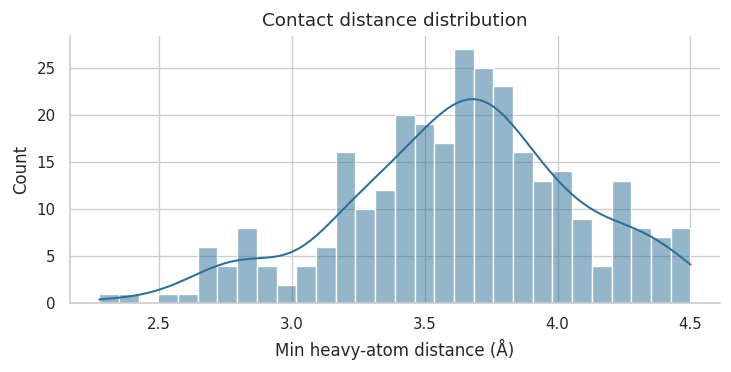

/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


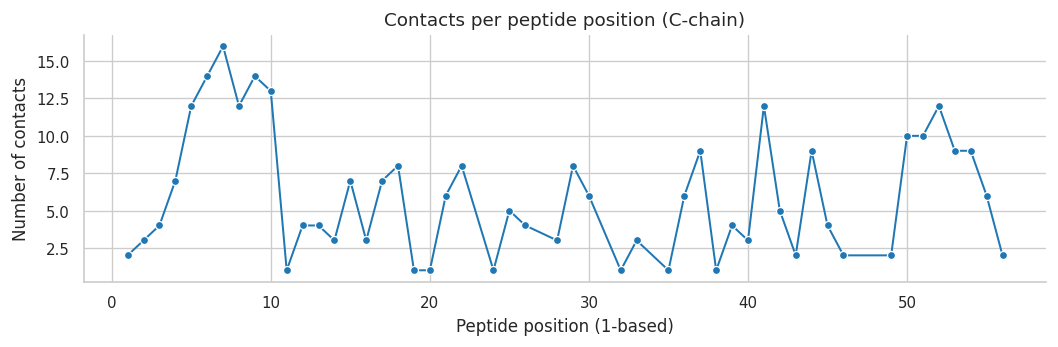

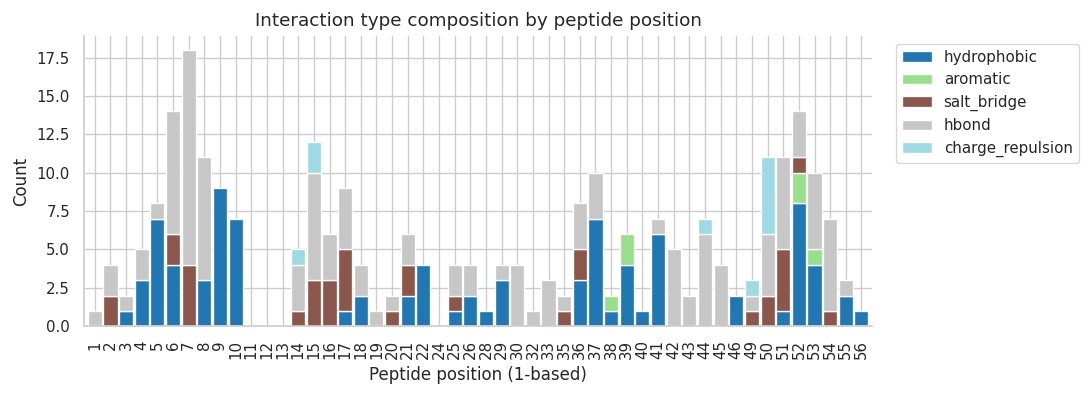

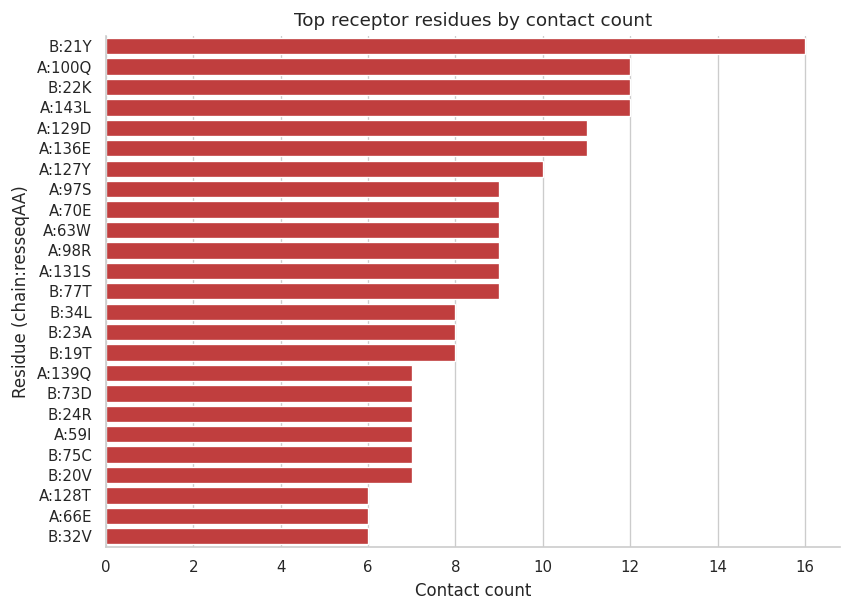

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1-based position for plots
df_contacts_plot = df_contacts.copy()
df_contacts_plot['pep_pos'] = df_contacts_plot['pep_index'] + 1
df_contacts_plot['rec_label'] = (
    df_contacts_plot['rec_chain'].astype(str)
    + ':' + df_contacts_plot['rec_resseq'].astype(str)
    + df_contacts_plot['rec_aa'].astype(str)
)

# (A) distance distribution
fig, ax = plt.subplots(figsize=(6.2, 3.2))
sns.histplot(df_contacts_plot['distance_A'], bins=30, kde=True, ax=ax, color='#2a6f97')
ax.set_title('Contact distance distribution')
ax.set_xlabel('Min heavy-atom distance (Å)')
ax.set_ylabel('Count')
savefig(fig, fig_dir / 'contact_distance_distribution.png')
plt.show()

# (B) contacts per peptide position
pos_counts = df_contacts_plot.groupby('pep_pos').size().rename('n_contacts').reset_index()
fig, ax = plt.subplots(figsize=(8.8, 3.0))
sns.lineplot(data=pos_counts, x='pep_pos', y='n_contacts', marker='o', ax=ax, color='#1f77b4')
ax.set_title('Contacts per peptide position (C-chain)')
ax.set_xlabel('Peptide position (1-based)')
ax.set_ylabel('Number of contacts')
savefig(fig, fig_dir / 'contacts_per_peptide_position.png')
plt.show()

# (C) interaction type composition per position
itypes = ['hydrophobic', 'aromatic', 'salt_bridge', 'hbond', 'charge_repulsion']
type_counts = df_contacts_plot.groupby('pep_pos')[itypes].sum()
fig, ax = plt.subplots(figsize=(9.2, 3.4))
type_counts.plot(kind='bar', stacked=True, ax=ax, width=0.9, colormap='tab20')
ax.set_title('Interaction type composition by peptide position')
ax.set_xlabel('Peptide position (1-based)')
ax.set_ylabel('Count')
ax.legend(title='', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)
savefig(fig, fig_dir / 'interaction_types_by_position.png')
plt.show()

# (D) top receptor residues (pocket)
rec_top = df_contacts_plot.groupby('rec_label').size().sort_values(ascending=False).head(25).reset_index(name='n')
fig, ax = plt.subplots(figsize=(7.2, 5.2))
sns.barplot(data=rec_top, x='n', y='rec_label', ax=ax, color='#d62828')
ax.set_title('Top receptor residues by contact count')
ax.set_xlabel('Contact count')
ax.set_ylabel('Residue (chain:resseqAA)')
savefig(fig, fig_dir / 'top_receptor_residues.png')
plt.show()


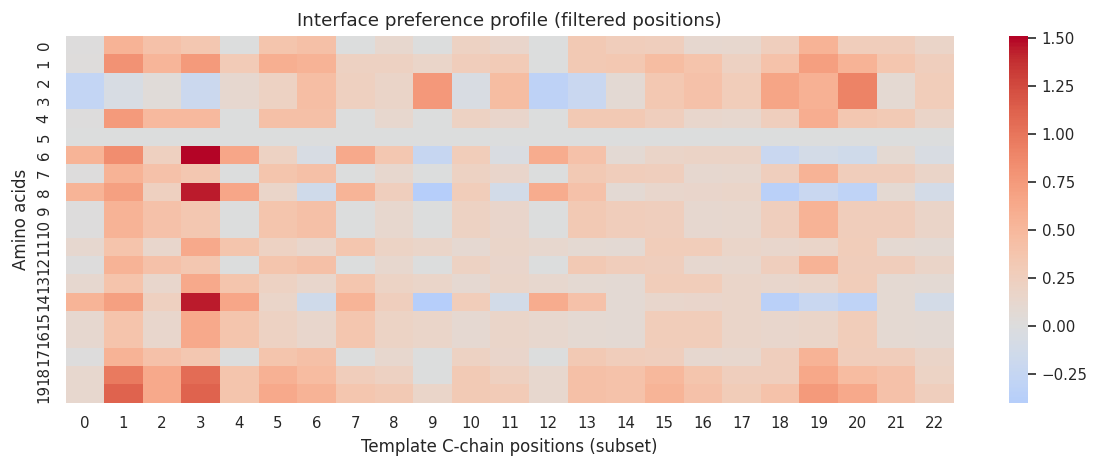

In [14]:
# 可解释图：每个 C 链位置对 20 种氨基酸的偏好（heatmap）
import matplotlib.pyplot as plt

mat = profile.profile
row_sums = np.abs(mat).sum(axis=1)
keep = row_sums > np.percentile(row_sums, 60)  # 只画相互作用更强的位置，让图更聚焦

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(mat[keep].T, cmap='coolwarm', center=0.0, ax=ax)
ax.set_title('Interface preference profile (filtered positions)')
ax.set_xlabel('Template C-chain positions (subset)')
ax.set_ylabel('Amino acids')
savefig(fig, fig_dir / 'interface_profile_heatmap.png')
plt.show()


## 4) 结构引导多肽生成（≤15 肽，分支迭代，亲和力不提升则停止）


In [15]:
from peptide_screening.design import beam_search_design
from peptide_screening.pipeline import candidates_to_frame

cands, history = beam_search_design(profile, design_cfg=cfg['design'], scoring_cfg=cfg['scoring'])
df_cands = candidates_to_frame(cands)
df_cands.head(20)


2026-01-01 00:24:50,191 | INFO | Design start | template_len=57 seed_len=7 max_len=15 beam_width=256 branch_factor=16


Design rounds:   0%|          | 0/20 [00:00<?, ?round/s]

2026-01-01 00:24:50,230 | INFO | Design round 1 | best=4.5210 len=8 start=2 beam=256
2026-01-01 00:24:50,353 | INFO | Design round 2 | best=5.0614 len=8 start=2 beam=256
2026-01-01 00:24:50,484 | INFO | Design round 3 | best=5.3579 len=8 start=2 beam=256
2026-01-01 00:24:50,616 | INFO | Design round 4 | best=5.5840 len=8 start=2 beam=256
2026-01-01 00:24:50,755 | INFO | Design round 5 | best=5.7761 len=8 start=2 beam=256
2026-01-01 00:24:50,889 | INFO | Design round 6 | best=5.8981 len=8 start=2 beam=256
2026-01-01 00:24:51,201 | INFO | Design round 7 | best=6.0158 len=8 start=2 beam=256
2026-01-01 00:24:51,391 | INFO | Design round 8 | best=6.1075 len=9 start=1 beam=256
2026-01-01 00:24:51,548 | INFO | Design round 9 | best=6.1801 len=9 start=1 beam=256
2026-01-01 00:24:51,691 | INFO | Design round 10 | best=6.2075 len=11 start=1 beam=256
2026-01-01 00:24:51,832 | INFO | Design round 11 | best=6.3471 len=12 start=1 beam=256
2026-01-01 00:24:51,984 | INFO | Design round 12 | best=6.416

start  end          peptide  length  score_affinity  score_contact  \
0       1   16  HHHYWHHYCEEEEHE      15        7.094140       6.790473   
1       1   16  HHHYWHHYCAEEEHE      15        7.092806       6.790473   
2       1   16  HHHYWHHYCEEEAHE      15        7.092806       6.790473   
3       1   16  HHHYWHHYCAEEAHE      15        7.091473       6.790473   
4       1   16  HHHYWHHYCEEELHE      15        7.090973       6.790473   
5       1   16  HHHYWHHYCAEELHE      15        7.089640       6.790473   
6       1   16  HHHYWHHYCEEEHHE      15        7.089306       6.790473   
7       1   16  HHHYWHHYCEEHEHE      15        7.089306       6.790473   
8       1   16  HHHYWHHYCEHEEHE      15        7.089306       6.790473   
9       1   16  HHHYWHHYCEEEMHE      15        7.088640       6.790473   
10      1   16  HHHYWHHYCEEEQHE      15        7.088140       6.790473   
11      1   16  HHHYWHHYCEEQEHE      15        7.088140       6.790473   
12      1   16  HHHYWHHYCEQEEHE      15        7.088140       6.790473   
13      1   16  HHHYWHHYCAEEHHE      15        7.087973       6.790473   
14      1   16  HHHYWHHYCEEHAHE      15        7.087973       6.790473   
15      1   16  HHHYWHHYCEHEAHE      15        7.087973       6.790473   
16      1   16  HHHYWHHYCAEHEHE      15        7.087973       6.790473   
17      1   16  HHHYWHHYCAHEEHE      15        7.087973       6.790473   
18      1   16  HHHYWHHYCEWEEHE      15        7.087640       6.790473   
19      1   16  HHHYWHHYCEEWEHE      15        7.087640       6.790473   

    score_helix  score_penalty  
0      0.303667            0.0  
1      0.302333            0.0  
2      0.302333            0.0  
3      0.301000            0.0  
4      0.300500            0.0  
5      0.299167            0.0  
6      0.298833            0.0  
7      0.298833            0.0  
8      0.298833            0.0  
9      0.298167            0.0  
10     0.297667            0.0  
11     0.297667            0.0  
12     0.297667            0.0  
13     0.297500            0.0  
14     0.297500            0.0  
15     0.297500            0.0  
16     0.297500            0.0  
17     0.297500            0.0  
18     0.297167            0.0  
19     0.297167            0.0

### 4.1 生成候选库的统计图（长度/分数/序列特征）


/home/xuchengjie/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


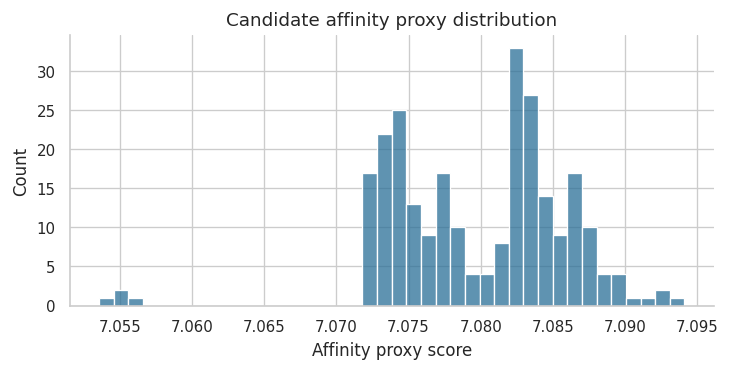

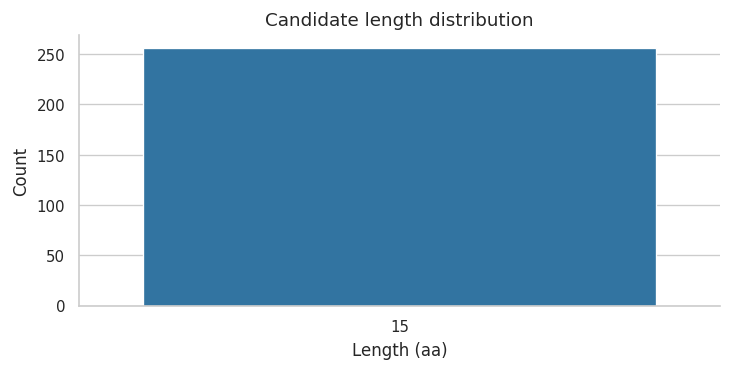

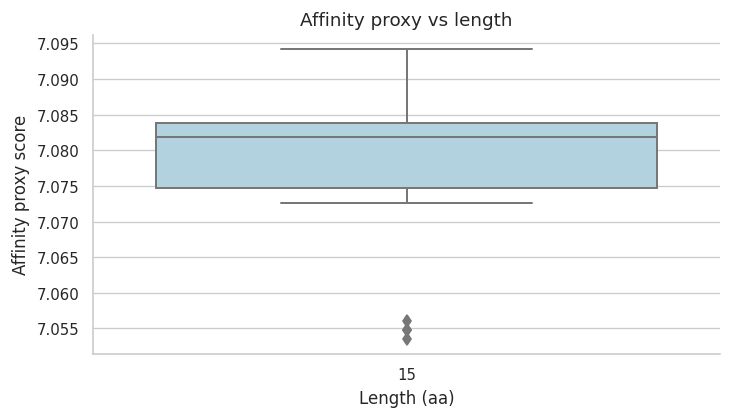

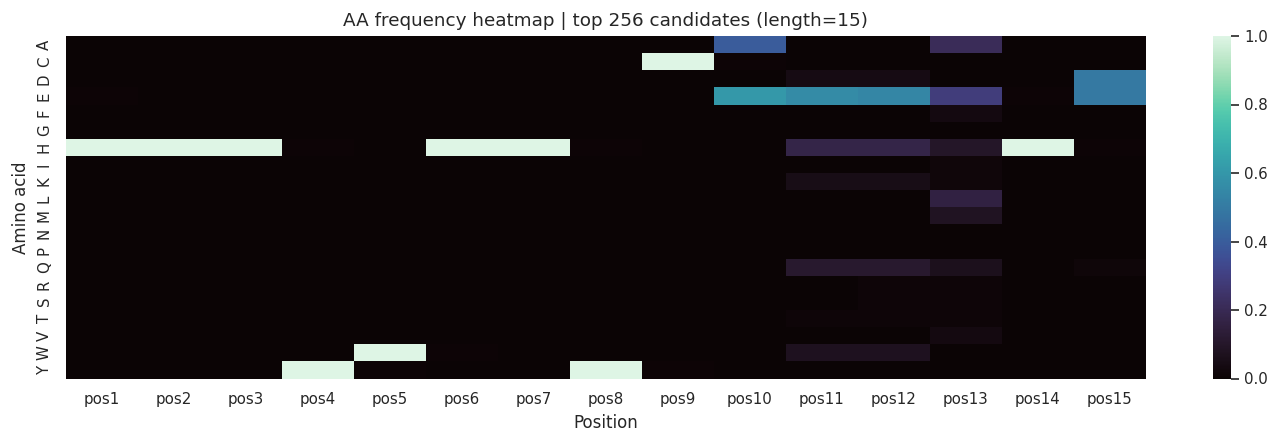

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from peptide_screening.data import STANDARD_AA

# (A) affinity score distribution
fig, ax = plt.subplots(figsize=(6.2, 3.2))
sns.histplot(df_cands['score_affinity'], bins=40, ax=ax, color='#2a6f97')
ax.set_title('Candidate affinity proxy distribution')
ax.set_xlabel('Affinity proxy score')
ax.set_ylabel('Count')
savefig(fig, fig_dir / 'candidate_affinity_distribution.png')
plt.show()

# (B) length distribution
fig, ax = plt.subplots(figsize=(6.2, 3.2))
sns.countplot(data=df_cands, x='length', ax=ax, color='#1f77b4')
ax.set_title('Candidate length distribution')
ax.set_xlabel('Length (aa)')
ax.set_ylabel('Count')
savefig(fig, fig_dir / 'candidate_length_distribution.png')
plt.show()

# (C) score vs length
fig, ax = plt.subplots(figsize=(6.2, 3.6))
sns.boxplot(data=df_cands, x='length', y='score_affinity', ax=ax, color='#a9d6e5')
ax.set_title('Affinity proxy vs length')
ax.set_xlabel('Length (aa)')
ax.set_ylabel('Affinity proxy score')
savefig(fig, fig_dir / 'affinity_vs_length_boxplot.png')
plt.show()

# (D) sequence frequency heatmap for length=15 top candidates
L = 15
sub = df_cands[df_cands['length'] == L].head(500)
if len(sub) > 0:
    seqs = sub['peptide'].tolist()
    freq = pd.DataFrame(0.0, index=[f'pos{i}' for i in range(1, L+1)], columns=list(STANDARD_AA))
    for s in seqs:
        for i, ch in enumerate(s[:L]):
            if ch in freq.columns:
                freq.iloc[i, freq.columns.get_loc(ch)] += 1
    freq = freq / len(seqs)

    fig, ax = plt.subplots(figsize=(12, 3.8))
    sns.heatmap(freq.T, cmap='mako', ax=ax)
    ax.set_title(f'AA frequency heatmap | top {len(seqs)} candidates (length={L})')
    ax.set_xlabel('Position')
    ax.set_ylabel('Amino acid')
    savefig(fig, fig_dir / 'aa_frequency_len15_heatmap.png')
    plt.show()
else:
    print('No length=15 candidates available for frequency heatmap.')


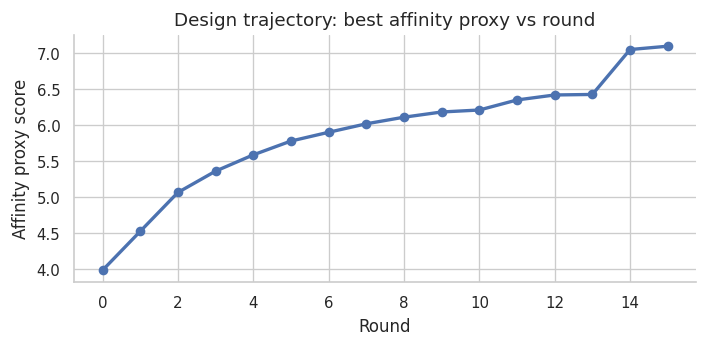

In [17]:
# 迭代曲线（生成轨迹）
import matplotlib.pyplot as plt
import pandas as pd

df_hist = pd.DataFrame([h.__dict__ for h in history])
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_hist['round_index'], df_hist['best_score'], marker='o', lw=2)
ax.set_title('Design trajectory: best affinity proxy vs round')
ax.set_xlabel('Round')
ax.set_ylabel('Affinity proxy score')
savefig(fig, fig_dir / 'design_best_score_curve.png')
plt.show()


## 5) 多模型筛选：螺旋/肿瘤靶向/穿膜/抗肿瘤/临床潜力


In [18]:
from peptide_screening.screening import score_with_models, apply_threshold_filters

df_scores = score_with_models(df_cands['peptide'].tolist(), models=models)
df_all = df_cands.merge(df_scores, on=['peptide','length'], how='left')

thresholds = {
    'p_helix': cfg['filters']['p_helix_min'],
    'p_tumor_targeting': cfg['filters']['p_tumor_targeting_min'],
    'p_cpp': cfg['filters']['p_cpp_min'],
    'p_anti_tumor': cfg['filters']['p_anti_tumor_min'],
    'p_clinical_dev': cfg['filters']['p_clinical_min'],
}

df_pass = apply_threshold_filters(df_all, thresholds)
df_pass = df_pass.sort_values('score_affinity', ascending=False).reset_index(drop=True)
df_pass.head(20)


2026-01-01 00:24:53,989 | INFO | Scoring 256 peptides with 5 models


Scoring helix:   0%|          | 0/1 [00:00<?, ?batch/s]

Scoring tumor_targeting:   0%|          | 0/1 [00:00<?, ?batch/s]

Scoring cpp:   0%|          | 0/1 [00:00<?, ?batch/s]

Scoring anti_tumor:   0%|          | 0/1 [00:00<?, ?batch/s]

Scoring clinical_dev:   0%|          | 0/1 [00:00<?, ?batch/s]

Empty DataFrame
Columns: [start, end, peptide, length, score_affinity, score_contact, score_helix, score_penalty, p_helix, p_tumor_targeting, p_cpp, p_anti_tumor, p_clinical_dev]
Index: []

### 5.1 多目标筛选可视化（亲和力 vs 多模型概率）


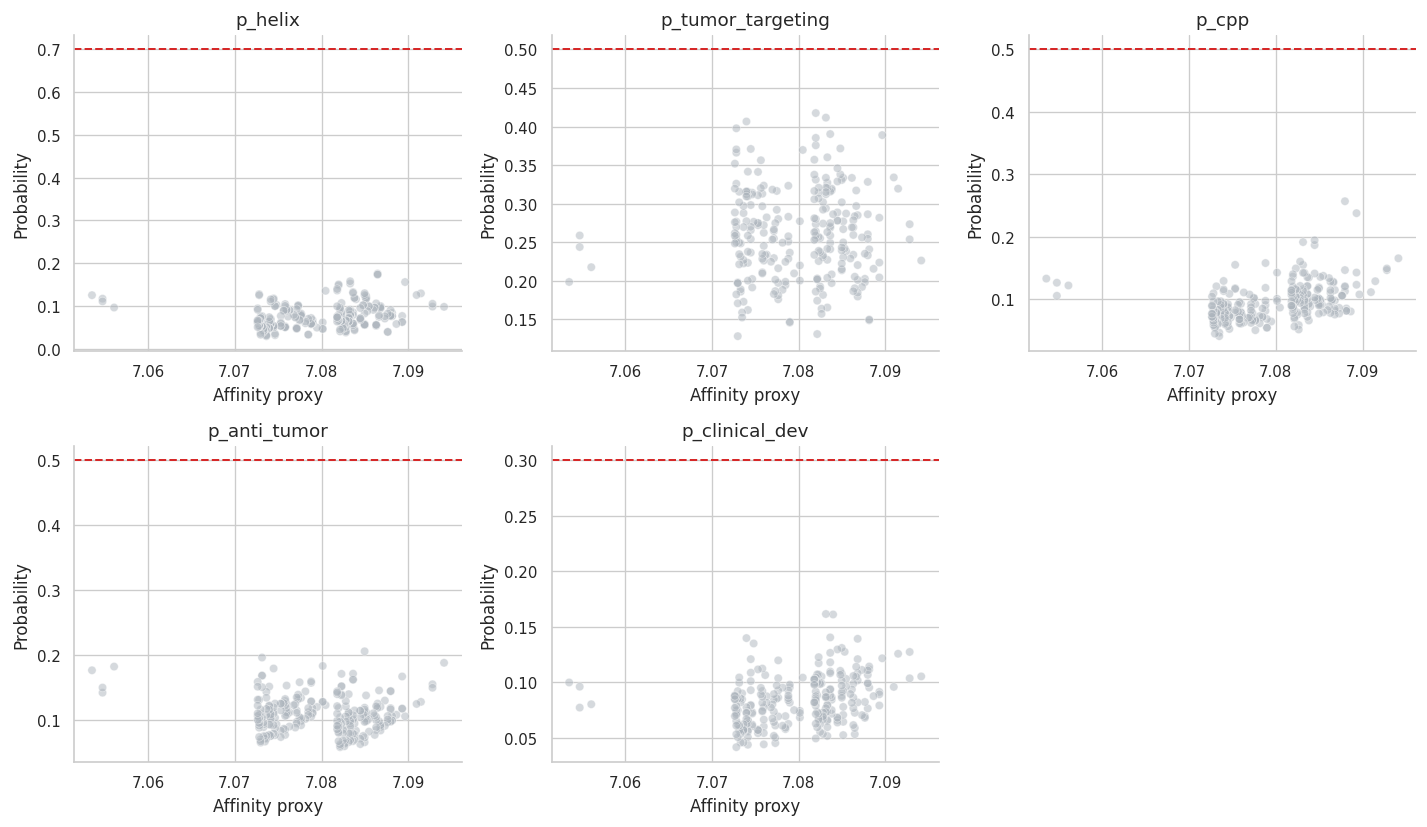

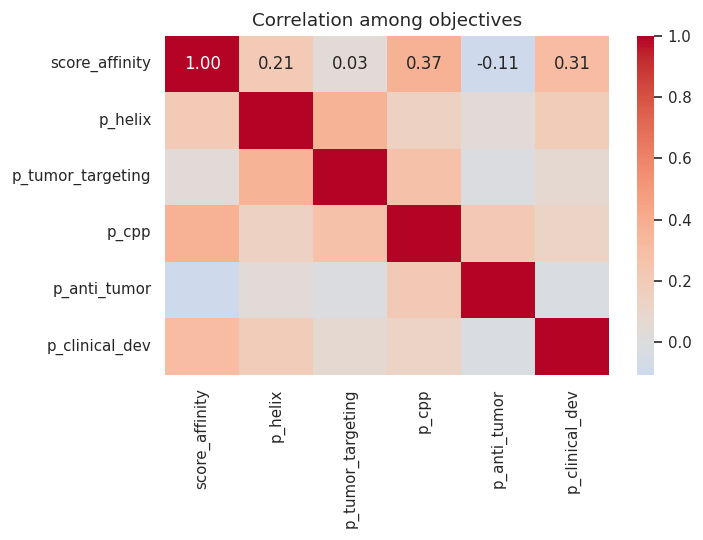

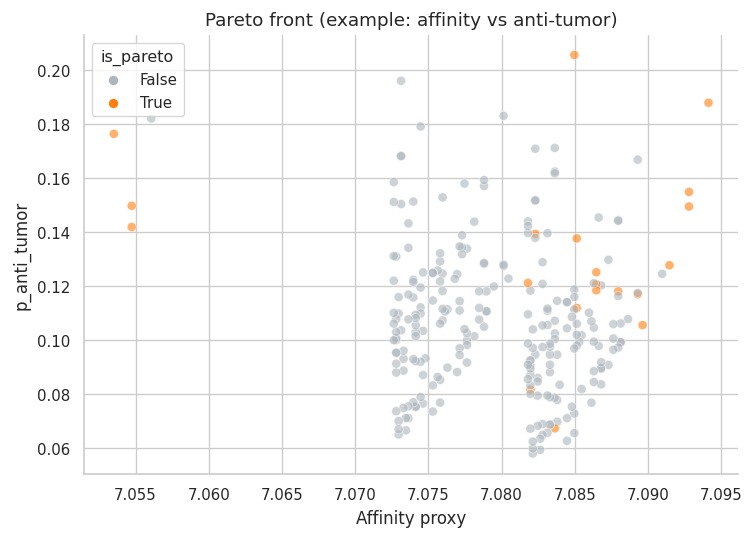

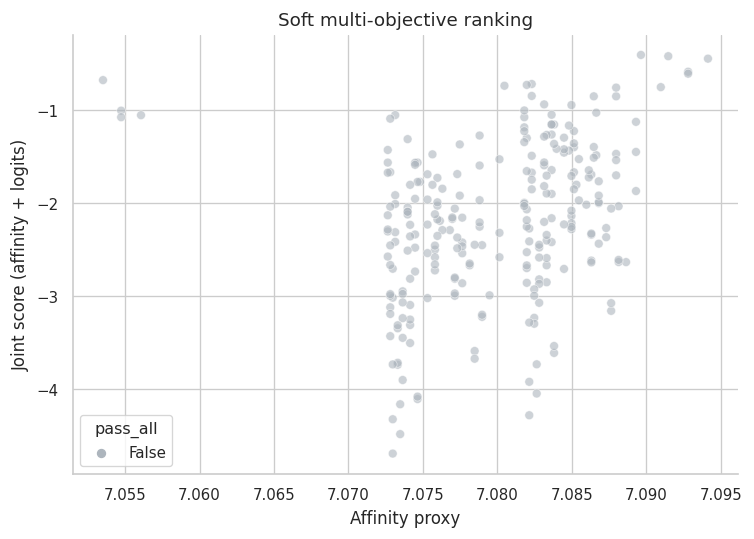

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from peptide_screening.multiobjective import pareto_front, weighted_logit_score

# 标记是否通过 hard-threshold
df_plot = df_all.copy()
df_plot['pass_all'] = df_plot['peptide'].isin(set(df_pass['peptide']))

# (A) affinity vs probabilities
prob_cols = ['p_helix', 'p_tumor_targeting', 'p_cpp', 'p_anti_tumor', 'p_clinical_dev']
thr = {
    'p_helix': float(cfg['filters']['p_helix_min']),
    'p_tumor_targeting': float(cfg['filters']['p_tumor_targeting_min']),
    'p_cpp': float(cfg['filters']['p_cpp_min']),
    'p_anti_tumor': float(cfg['filters']['p_anti_tumor_min']),
    'p_clinical_dev': float(cfg['filters']['p_clinical_min']),
}

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()
for ax, col in zip(axes, prob_cols):
    sns.scatterplot(
        data=df_plot,
        x='score_affinity',
        y=col,
        hue='pass_all',
        palette={False: '#adb5bd', True: '#2a9d8f'},
        alpha=0.5,
        s=25,
        ax=ax,
        legend=False,
    )
    ax.axhline(thr[col], ls='--', lw=1.2, color='#d62828')
    ax.set_title(col)
    ax.set_xlabel('Affinity proxy')
    ax.set_ylabel('Probability')

axes[-1].axis('off')
savefig(fig, fig_dir / 'affinity_vs_probabilities.png')
plt.show()

# (B) correlation heatmap
fig, ax = plt.subplots(figsize=(6.2, 4.6))
corr = df_plot[['score_affinity'] + prob_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0.0, annot=True, fmt='.2f', ax=ax)
ax.set_title('Correlation among objectives')
savefig(fig, fig_dir / 'objective_correlation_heatmap.png')
plt.show()

# (C) Pareto front (affinity + selected probabilities)
df_plot['is_pareto'] = pareto_front(df_plot, maximize=['score_affinity', 'p_helix', 'p_cpp', 'p_anti_tumor']).values
fig, ax = plt.subplots(figsize=(6.4, 4.6))
sns.scatterplot(data=df_plot, x='score_affinity', y='p_anti_tumor', hue='is_pareto',
                palette={False:'#adb5bd', True:'#ff7f0e'}, alpha=0.6, s=30, ax=ax)
ax.set_title('Pareto front (example: affinity vs anti-tumor)')
ax.set_xlabel('Affinity proxy')
ax.set_ylabel('p_anti_tumor')
savefig(fig, fig_dir / 'pareto_front_affinity_vs_anti_tumor.png')
plt.show()

# (D) soft ranking fallback：当 hard filter 为空时仍可产出 top10
weights = {
    'p_helix': 1.0,
    'p_tumor_targeting': 0.8,
    'p_cpp': 0.8,
    'p_anti_tumor': 1.2,
    'p_clinical_dev': 0.6,
}
df_plot['score_joint'] = weighted_logit_score(df_plot, prob_cols=weights, base_col='score_affinity', base_weight=1.0)

fig, ax = plt.subplots(figsize=(6.4, 4.6))
sns.scatterplot(data=df_plot, x='score_affinity', y='score_joint', hue='pass_all',
                palette={False:'#adb5bd', True:'#2a9d8f'}, alpha=0.6, s=28, ax=ax)
ax.set_title('Soft multi-objective ranking')
ax.set_xlabel('Affinity proxy')
ax.set_ylabel('Joint score (affinity + logits)')
savefig(fig, fig_dir / 'soft_ranking_scatter.png')
plt.show()


In [20]:
out_csv = run_dir / 'candidates_pass_all_filters.csv'
df_pass.to_csv(out_csv, index=False)
print('saved:', out_csv)


saved: results/20260101_002417/candidates_pass_all_filters.csv


## 6) （可选）TARSA 风格的“后验采样”筛库

当候选库非常大（>10^6）且“结构打分/ESMFold”计算代价较高时：
- 先用 ESM2 embedding → PCA2 构建低维 landscape
- 聚类得到 hotspots
- Thompson sampling 优先把预算花在高回报 hotspots


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from peptide_screening.affinity import best_window_score
from peptide_screening.embeddings import embed_sequences_mean_pool, load_esm2_embedder
from peptide_screening.tarsa import build_hotspots, pca2, thompson_screen


RUN_TARSA = False

tarsa_cfg = {
    "esm2_model_id": "facebook/esm2_t12_35M_UR50D",
    "sample_n": 3000 if QUICK_MODE else 20000,
    "embed_batch_size": 64,
    "n_hotspots": 30,
    "budget": 1500 if QUICK_MODE else 8000,
    "screen_batch_size": 64,
}

if not RUN_TARSA:
    print("Set RUN_TARSA=True to run TARSA-like screening.")
else:
    rng = np.random.default_rng(int(cfg["run"]["random_seed"]))
    seqs_all = df_cands["peptide"].astype(str).tolist()
    if len(seqs_all) == 0:
        raise RuntimeError("df_cands is empty")

    sample_n = int(min(tarsa_cfg["sample_n"], len(seqs_all)))
    if sample_n < len(seqs_all):
        idx = rng.choice(len(seqs_all), size=sample_n, replace=False)
        seqs = [seqs_all[i] for i in idx.tolist()]
    else:
        seqs = seqs_all

    if "logger" in globals():
        logger.info("TARSA-like | sampling n=%d from total=%d", len(seqs), len(seqs_all))

    embedder = load_esm2_embedder(
        model_id=tarsa_cfg["esm2_model_id"],
        device="auto",
        dtype="auto",
    )
    emb = embed_sequences_mean_pool(
        embedder,
        seqs,
        batch_size=int(tarsa_cfg["embed_batch_size"]),
        show_progress=True,
    )
    coords = pca2(emb, seed=int(cfg["run"]["random_seed"]))
    labels = build_hotspots(
        coords,
        n_hotspots=int(tarsa_cfg["n_hotspots"]),
        seed=int(cfg["run"]["random_seed"]),
    )

    def oracle(batch: list[str]) -> np.ndarray:
        return np.array(
            [best_window_score(profile, s, scoring_cfg=cfg["scoring"]).score_affinity for s in batch],
            dtype=float,
        )

    picked = thompson_screen(
        seqs=seqs,
        coords_2d=coords,
        hotspot_labels=labels,
        oracle=oracle,
        budget=int(tarsa_cfg["budget"]),
        batch_size=int(tarsa_cfg["screen_batch_size"]),
        seed=int(cfg["run"]["random_seed"]),
        show_progress=True,
    )

    df_land = pd.DataFrame({"x": coords[:, 0], "y": coords[:, 1], "hotspot": labels.astype(int)})
    df_land["peptide"] = seqs

    picked_idx = picked["picked_idx"].astype(int)
    picked_reward = picked["picked_reward"].astype(float)
    df_picked = pd.DataFrame({"peptide": [seqs[i] for i in picked_idx], "reward": picked_reward})
    df_picked = df_picked.sort_values("reward", ascending=False).reset_index(drop=True)
    out_csv = run_dir / "tarsa_like_picked.csv"
    df_picked.to_csv(out_csv, index=False)

    # (A) low-dimensional landscape (hotspots)
    fig, ax = plt.subplots(figsize=(7.2, 5.6))
    sns.scatterplot(data=df_land, x="x", y="y", hue="hotspot", palette="tab20", s=14, alpha=0.7, ax=ax, legend=False)
    ax.set_title("ESM2 embedding landscape (PCA2) with hotspots")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    savefig(fig, fig_dir / "tarsa_landscape_hotspots.png")
    plt.show()

    # (B) picked points overlay
    df_land["picked"] = False
    df_land.loc[picked_idx.tolist(), "picked"] = True
    fig, ax = plt.subplots(figsize=(7.2, 5.6))
    sns.scatterplot(data=df_land, x="x", y="y", hue="picked", palette={False: "#adb5bd", True: "#d62828"}, s=16, alpha=0.75, ax=ax)
    ax.set_title("TARSA-like selection over landscape")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    savefig(fig, fig_dir / "tarsa_picked_overlay.png")
    plt.show()

    # (C) reward trajectory
    best_so_far = np.maximum.accumulate(picked_reward)
    fig, ax = plt.subplots(figsize=(7.0, 3.2))
    ax.plot(np.arange(1, len(best_so_far) + 1), best_so_far, lw=2)
    ax.set_title("TARSA-like reward trajectory (best-so-far)")
    ax.set_xlabel("Oracle calls")
    ax.set_ylabel("Affinity proxy (best-so-far)")
    savefig(fig, fig_dir / "tarsa_reward_trajectory.png")
    plt.show()

    # Top candidates table
    topk = df_picked.head(10).copy()
    fig, ax = plt.subplots(figsize=(11.5, 2.2))
    ax.axis("off")
    table = ax.table(
        cellText=[[r["peptide"], f"{float(r['reward']):.3f}"] for _, r in topk.iterrows()],
        colLabels=["peptide", "reward"],
        loc="center",
        cellLoc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.0, 1.25)
    ax.set_title("Top TARSA-like selected peptides", pad=10)
    savefig(fig, fig_dir / "tarsa_top10_table.png")
    plt.show()


Set RUN_TARSA=True to run TARSA-like screening.


## 7) ESMFold：对最终前 10 多肽进行 A/B 链复合物建模

推荐两种后端（按“是否需要真实多链复合物”选择）：
- `fair-esm`（推荐）：用于 `A:B:peptide` 真实多链；需要 `.pt` checkpoint；若本地没有会自动下载 `esmfold_3B_v1.pt`。
- `transformers`：可直接加载本地 `ESM_Fold2.bin`；但对多链复合物通常等价于“拼接成单链”的近似，不适用于需要链分离解释的复合物结论。

速度参考（RTX 4080，A≈247 aa, B≈260 aa, peptide≤15 aa，总长≈520，recycles=4）：单个复合物通常为几十秒到数分钟；可先用 `top10.head(1)` 做小规模验证，再扩展到 Top10。


A len 247 B len 260
Hard-threshold 结果为空：使用 soft multi-objective ranking 选择 top10（用于后续结构建模）


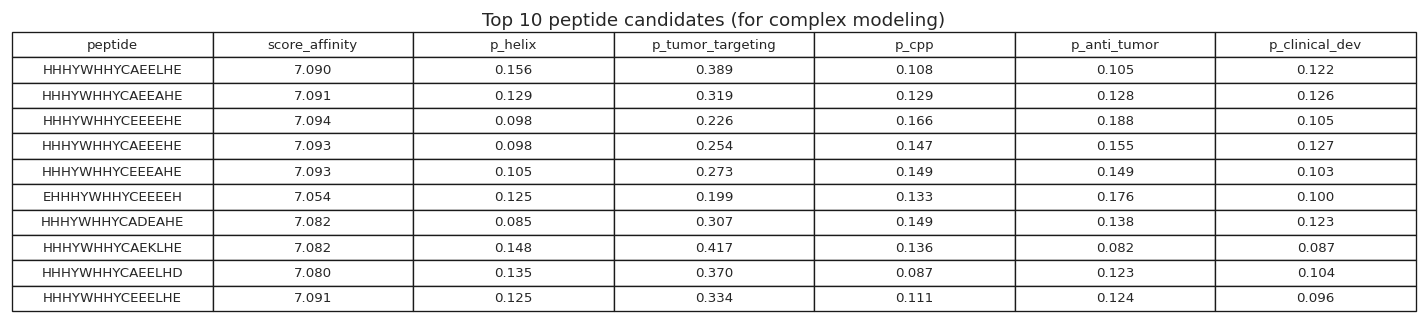

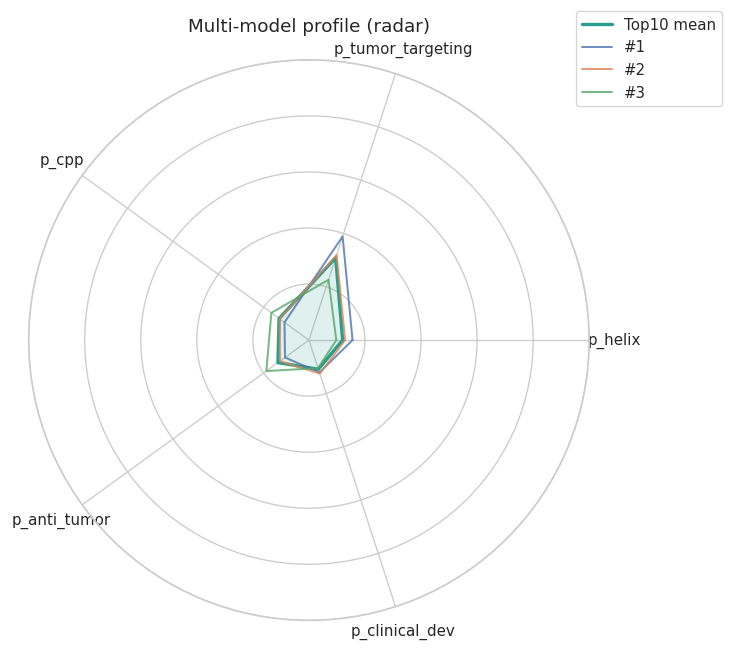

In [22]:
from Bio.PDB import PDBParser
from peptide_screening.structure import chain_sequence
from peptide_screening.multiobjective import weighted_logit_score

# 提取 A/B 链序列（以 backbone_template 为准）
parser = PDBParser(QUIET=True)
structure = parser.get_structure('tmpl', cfg['structure']['backbone_template'])
model = next(structure.get_models())
seqA = chain_sequence(model['A'])
seqB = chain_sequence(model['B'])
print('A len', len(seqA), 'B len', len(seqB))

# Top10 selection: use hard-threshold set when available; otherwise fall back to soft ranking.
if df_pass.empty:
    print('Hard-threshold 结果为空：使用 soft multi-objective ranking 选择 top10（用于后续结构建模）')
    weights = {
        'p_helix': 1.0,
        'p_tumor_targeting': 0.8,
        'p_cpp': 0.8,
        'p_anti_tumor': 1.2,
        'p_clinical_dev': 0.6,
    }
    df_rank = df_all.copy()
    df_rank['score_joint'] = weighted_logit_score(df_rank, prob_cols=weights, base_col='score_affinity', base_weight=1.0)
    top10 = df_rank.sort_values('score_joint', ascending=False).head(10).copy()
else:
    print('使用 hard-threshold 通过集合的 top10')
    top10 = df_pass.head(10).copy()

# 输出候选肽汇总表（Top candidates）
import matplotlib.pyplot as plt

cols = ['peptide', 'score_affinity', 'p_helix', 'p_tumor_targeting', 'p_cpp', 'p_anti_tumor', 'p_clinical_dev']
show_df = top10[cols].copy()
for c in cols[1:]:
    show_df[c] = show_df[c].astype(float).map(lambda x: f'{x:.3f}')

fig, ax = plt.subplots(figsize=(12, 2.8))
ax.axis('off')
table = ax.table(
    cellText=show_df.values.tolist(),
    colLabels=show_df.columns.tolist(),
    loc='center',
    cellLoc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.0, 1.3)
ax.set_title('Top 10 peptide candidates (for complex modeling)', pad=12)
savefig(fig, fig_dir / 'top10_candidates_table.png')
plt.show()

# 雷达图（展示 top10 的多模型预测“画像”）
import numpy as np

prob_cols = ['p_helix', 'p_tumor_targeting', 'p_cpp', 'p_anti_tumor', 'p_clinical_dev']
vals = top10[prob_cols].astype(float).to_numpy()
avg = vals.mean(axis=0)

labels = prob_cols
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])

fig = plt.figure(figsize=(6.2, 6.2))
ax = plt.subplot(111, polar=True)

# 平均轮廓
avg_plot = np.concatenate([avg, avg[:1]])
ax.plot(angles, avg_plot, color='#2a9d8f', lw=2, label='Top10 mean')
ax.fill(angles, avg_plot, color='#2a9d8f', alpha=0.15)

# 叠加前 3 条（突出）
for i in range(min(3, len(top10))):
    v = vals[i]
    v_plot = np.concatenate([v, v[:1]])
    ax.plot(angles, v_plot, lw=1.2, alpha=0.8, label=f'#{i+1}')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticklabels([])
ax.set_ylim(0, 1)
ax.set_title('Multi-model profile (radar)')
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.10), frameon=True)
savefig(fig, fig_dir / 'top10_radar_profile.png')
plt.show()


In [23]:
# 运行 ESMFold（A/B + peptide 复合物）
# 说明：
# - BACKEND='fair-esm'：推荐（真正支持多链 `A:B:peptide`）
# - BACKEND='transformers'：可直接加载本地 `ESM_Fold2.bin`，但对多链通常等价于“拼接单链”近似

from pathlib import Path
import time

import torch
from tqdm.auto import tqdm

from peptide_screening.esmfold import (
    infer_complex_pdb,
    load_esmfold_fair_esm,
    load_esmfold_transformers,
    save_pdb,
)

RUN_ESMFOLD = False
BACKEND = 'fair-esm'  # 'fair-esm' / 'transformers'

weights_path = Path(cfg['paths'].get('esmfold_weights', 'ESM_Fold2.bin'))

if not RUN_ESMFOLD:
    print('Set RUN_ESMFOLD=True to run ESMFold (can be slow).')
else:
    if BACKEND == 'fair-esm':
        runner = load_esmfold_fair_esm(
            device=cfg['esmfold']['device'],
            chunk_size=cfg['esmfold']['chunk_size'],
            show_progress=True,
        )
    elif BACKEND == 'transformers':
        runner = load_esmfold_transformers(
            hf_model_id=cfg['esmfold']['hf_model_id'],
            weights_path=weights_path,
            device=cfg['esmfold']['device'],
            dtype=cfg['esmfold']['dtype'],
            chunk_size=cfg['esmfold']['chunk_size'],
            show_progress=True,
        )
        print('[warn] transformers backend may not preserve true chain breaks for complexes.')
    else:
        raise ValueError(f'Unknown BACKEND={BACKEND!r}')

    out_pdb_dir = run_dir / f"esmfold_complex_{BACKEND}"
    out_pdb_dir.mkdir(parents=True, exist_ok=True)

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    peptides = top10['peptide'].tolist()
    for rank, pep in enumerate(tqdm(peptides, desc='ESMFold complexes', unit='pep'), start=1):
        t0 = time.perf_counter()
        pdb_str = infer_complex_pdb(
            runner,
            chain_a=seqA,
            chain_b=seqB,
            peptide=pep,
            num_recycles=int(cfg['esmfold']['max_recycles']),
        )
        dt = time.perf_counter() - t0

        safe = pep.replace('/', '_')
        out_pdb = out_pdb_dir / f"{rank:02d}_{safe}.pdb"
        save_pdb(pdb_str, out_pdb)

        if 'logger' in globals():
            logger.info('ESMFold | backend=%s rank=%d pep_len=%d time_s=%.2f out=%s', BACKEND, rank, len(pep), dt, str(out_pdb))
        else:
            print(f'ESMFold | backend={BACKEND} rank={rank} pep_len={len(pep)} time_s={dt:.2f} out={out_pdb}')

    if torch.cuda.is_available():
        peak_gb = torch.cuda.max_memory_allocated() / 1024**3
        if 'logger' in globals():
            logger.info('ESMFold peak cuda memory (alloc) = %.2f GB', peak_gb)
        else:
            print('ESMFold peak cuda memory (alloc) =', peak_gb, 'GB')

    print('saved esmfold pdbs to', out_pdb_dir)


Set RUN_ESMFOLD=True to run ESMFold (can be slow).


## 8) 复合物可视化与相互作用分析（氨基酸分辨率）

输出内容：
- 逐残基 B-factor/置信度曲线（ESMFold 输出通常将 pLDDT 写入 B-factor）
- 氨基酸-氨基酸相互作用事件表（氢键/盐桥/疏水/π-π/cation-π）与统计汇总
- 强度指标：盐桥/电荷排斥使用库仑能（kcal/mol，介电常数可配置）；其余为几何与接触的强度评分（用于排序与可视化）
- 结合口袋残基的跨候选肽统计（频次与强度）


In [24]:
from pathlib import Path

analysis_dir = run_dir / "interaction_analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

pdb_dirs = sorted([p for p in run_dir.glob("esmfold_complex_*") if p.is_dir()])
pdb_paths = []
for d in pdb_dirs:
    pdb_paths.extend(sorted(d.glob("*.pdb")))

if pdb_paths:
    print(f"Using ESMFold complexes: n={len(pdb_paths)} dir={pdb_paths[0].parent}")
else:
    pdb_paths = [Path(p) for p in cfg["paths"]["pdb_files"]]
    print("No ESMFold outputs found in this run_dir; using template PDBs:", [p.name for p in pdb_paths])

pdb_by_id = {p.stem: p for p in pdb_paths}
pdb_paths


No ESMFold outputs found in this run_dir; using template PDBs: ['6P8E.pdb', '6P8F.pdb', '6P8G.pdb']


[PosixPath('6P8E.pdb'), PosixPath('6P8F.pdb'), PosixPath('6P8G.pdb')]

B-factor extraction:   0%|          | 0/3 [00:00<?, ?pdb/s]

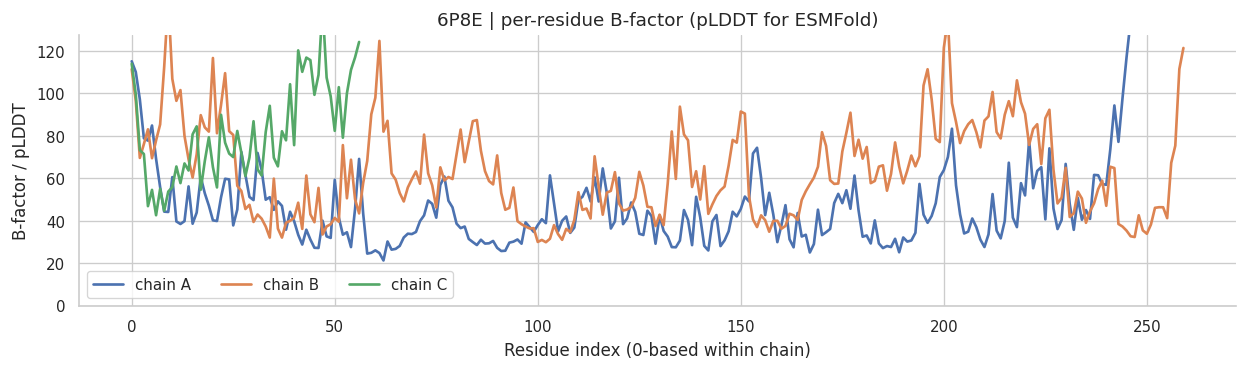

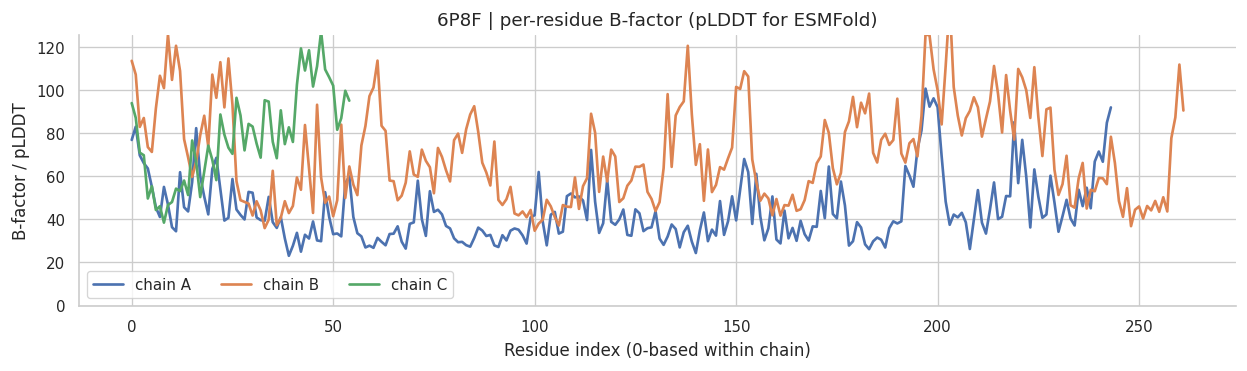

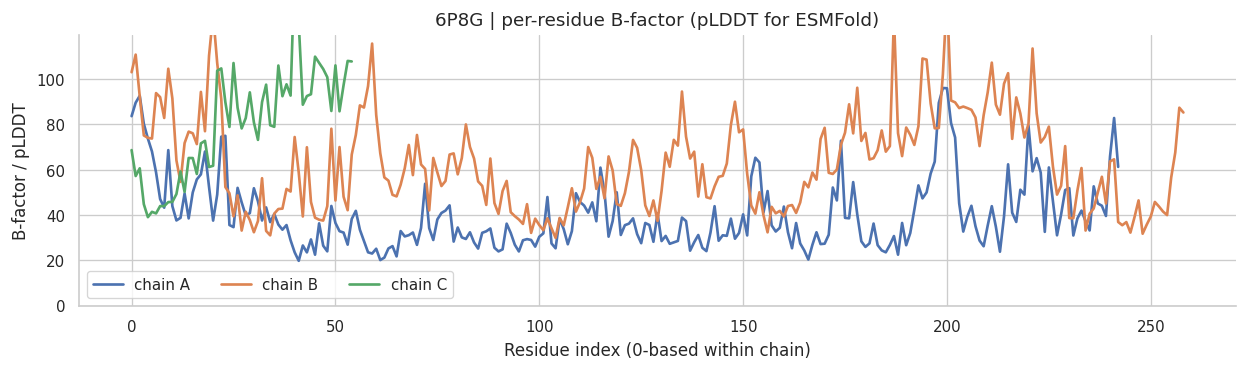

complex chain  mean_bfactor
0    6P8E     A     45.085991
1    6P8E     B     63.005425
2    6P8E     C     81.518643
3    6P8F     A     43.706373
4    6P8F     B     69.839498
5    6P8F     C     78.646452
6    6P8G     A     39.952990
7    6P8G     B     62.747831
8    6P8G     C     80.371529

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from peptide_screening.interaction_analysis import extract_residue_plddt

plddt_all = []
for pdb_path in tqdm(pdb_paths, desc="B-factor extraction", unit="pdb"):
    df = extract_residue_plddt(pdb_path)
    df["complex"] = pdb_path.stem
    plddt_all.append(df)

    if df.empty:
        continue

    fig, ax = plt.subplots(figsize=(10.5, 3.2))
    for chain_id, sub in df.groupby("chain"):
        ax.plot(sub["index"], sub["plddt"], lw=1.6, label=f"chain {chain_id}")

    ymax = float(np.nanpercentile(df["plddt"].to_numpy(), 99))
    ax.set_ylim(0, max(100.0, ymax + 5.0))
    ax.set_title(f"{pdb_path.stem} | per-residue B-factor (pLDDT for ESMFold)")
    ax.set_xlabel("Residue index (0-based within chain)")
    ax.set_ylabel("B-factor / pLDDT")
    ax.legend(frameon=True, ncols=3)
    savefig(fig, fig_dir / f"complex_{pdb_path.stem}_bfactor.png")
    plt.show()

df_plddt = pd.concat(plddt_all, ignore_index=True) if plddt_all else pd.DataFrame()
df_plddt.to_csv(analysis_dir / "complex_residue_bfactor_table.csv", index=False)
df_plddt_summary = (
    df_plddt.groupby(["complex", "chain"], as_index=False)["plddt"].mean().rename(columns={"plddt": "mean_bfactor"})
    if not df_plddt.empty
    else pd.DataFrame(columns=["complex", "chain", "mean_bfactor"])
)
df_plddt_summary.to_csv(analysis_dir / "complex_chain_bfactor_summary.csv", index=False)
df_plddt_summary


Interaction analysis:   0%|          | 0/3 [00:00<?, ?pdb/s]

2026-01-01 00:24:58,053 | INFO | Interaction analysis start | pdb=6P8E.pdb
2026-01-01 00:24:58,112 | INFO | Interaction analysis done | pdb=6P8E.pdb events=53


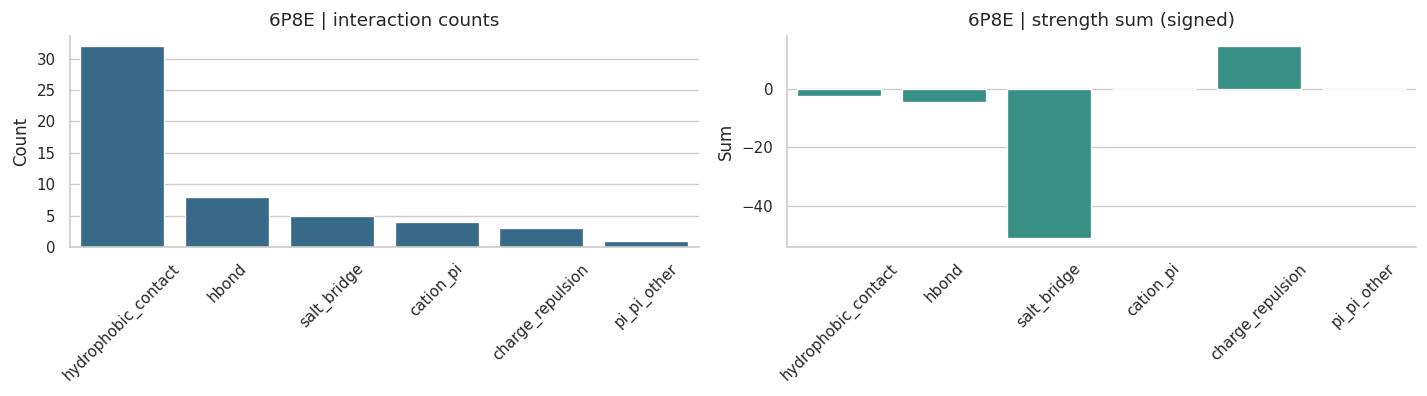

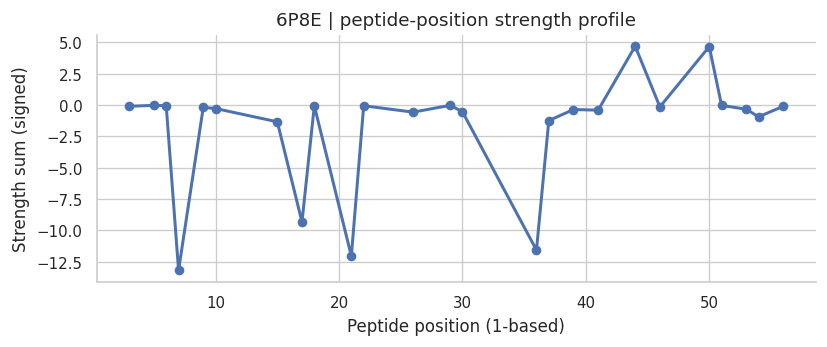

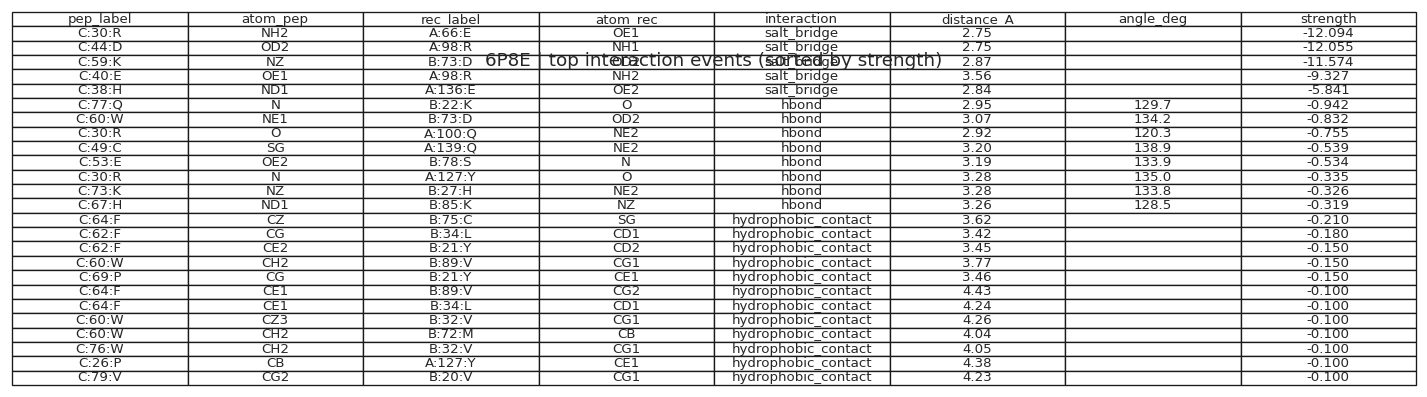

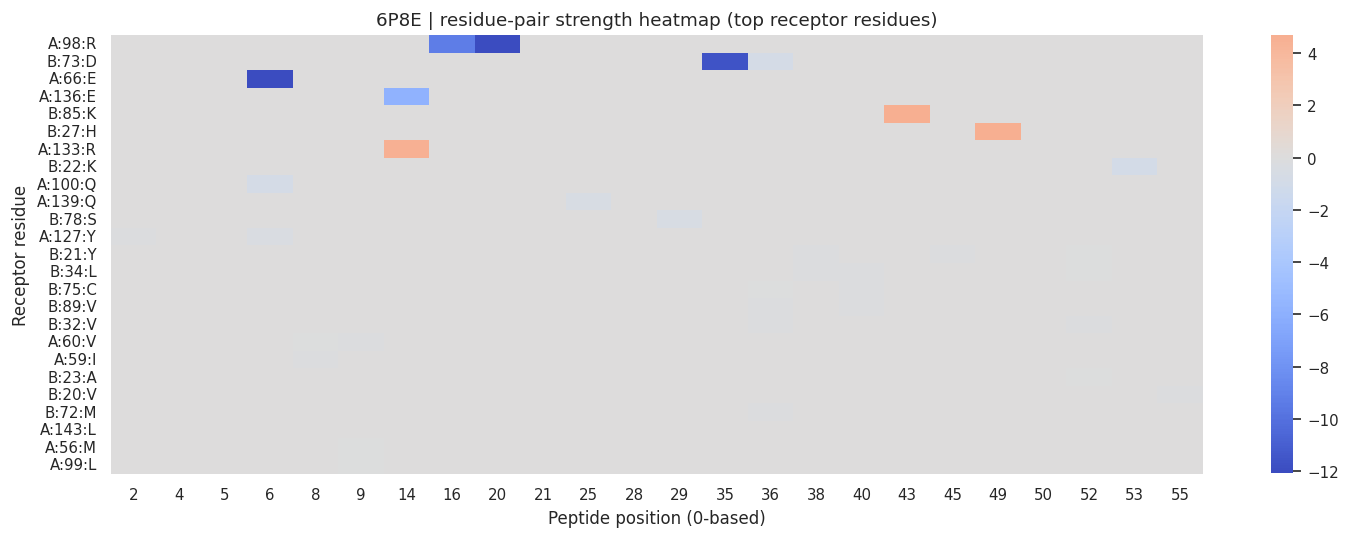

2026-01-01 00:25:00,144 | INFO | Interaction analysis start | pdb=6P8F.pdb
2026-01-01 00:25:00,202 | INFO | Interaction analysis done | pdb=6P8F.pdb events=45


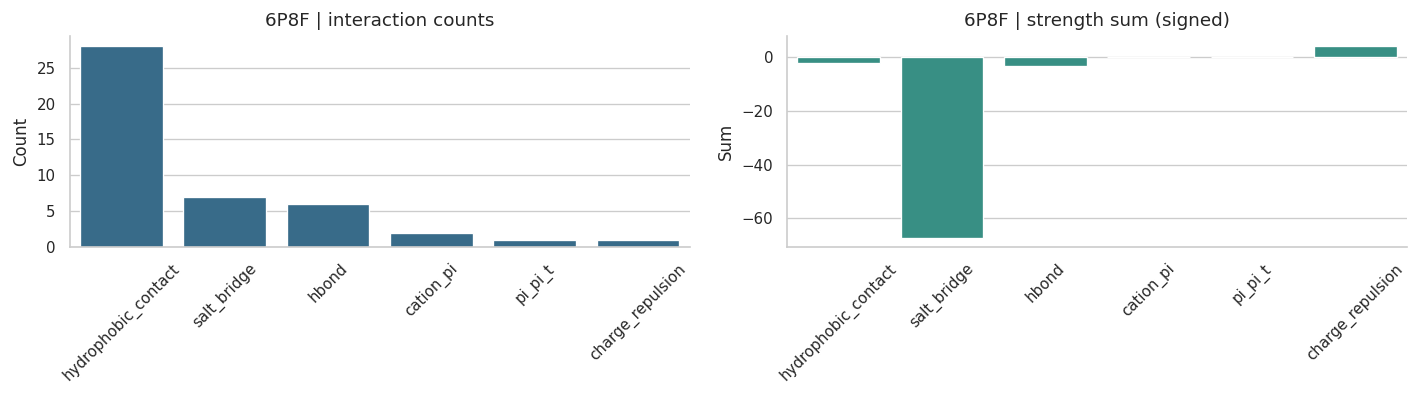

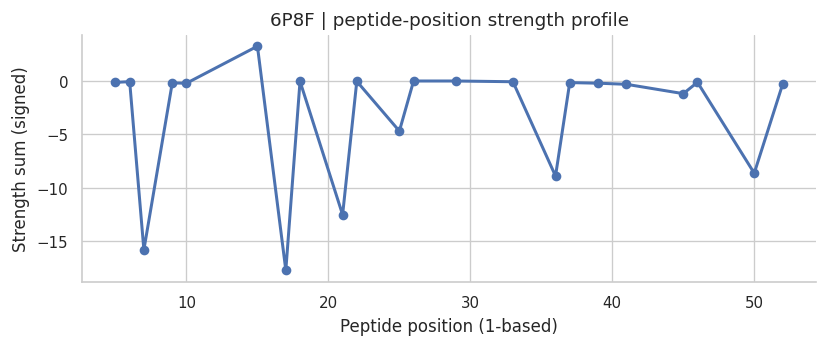

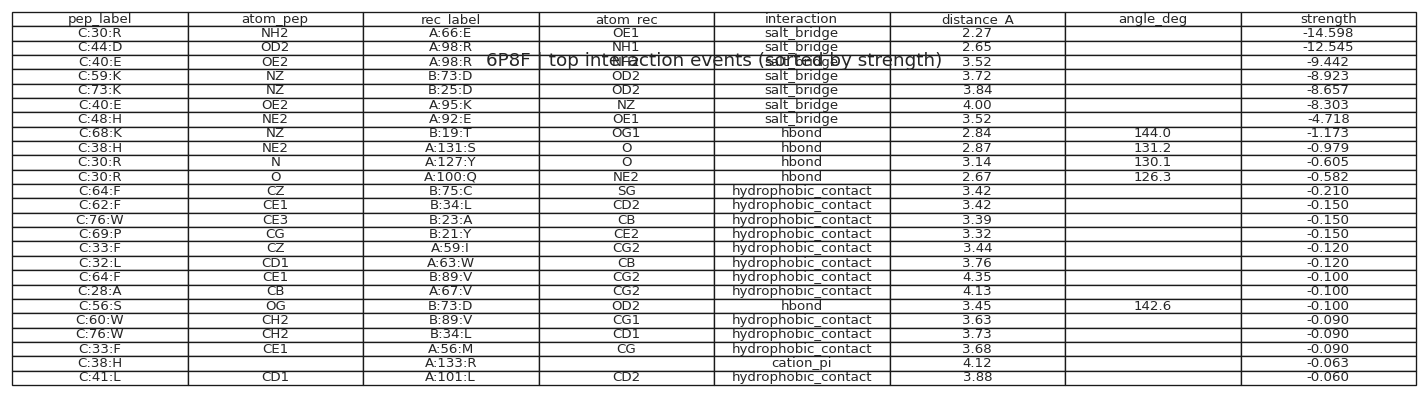

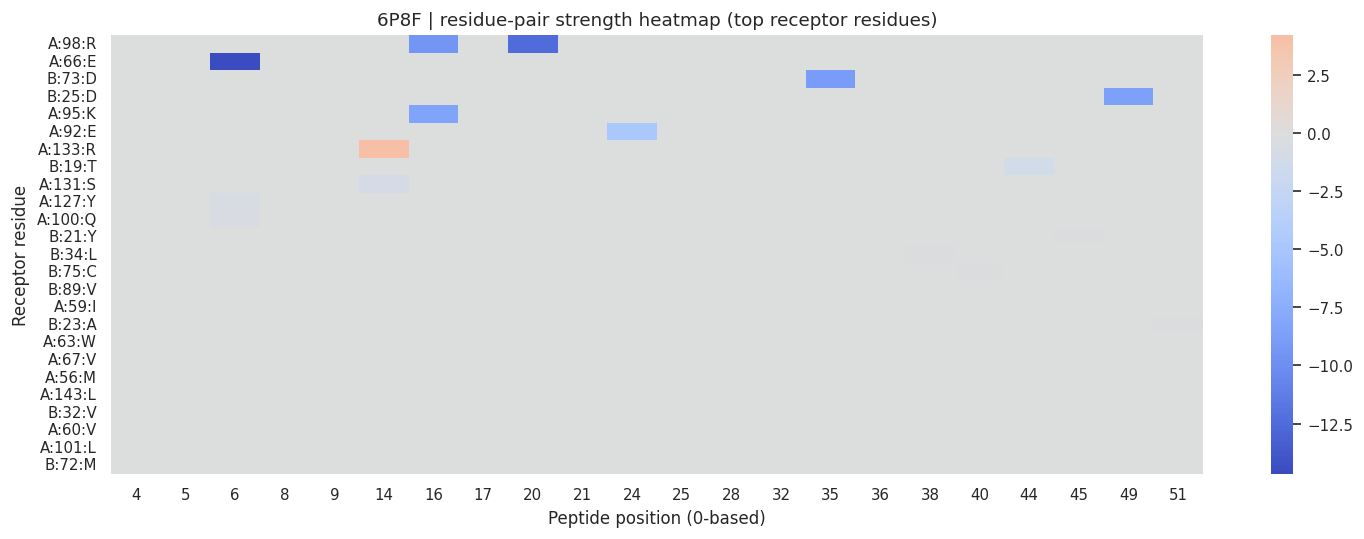

2026-01-01 00:25:02,033 | INFO | Interaction analysis start | pdb=6P8G.pdb
2026-01-01 00:25:02,086 | INFO | Interaction analysis done | pdb=6P8G.pdb events=42


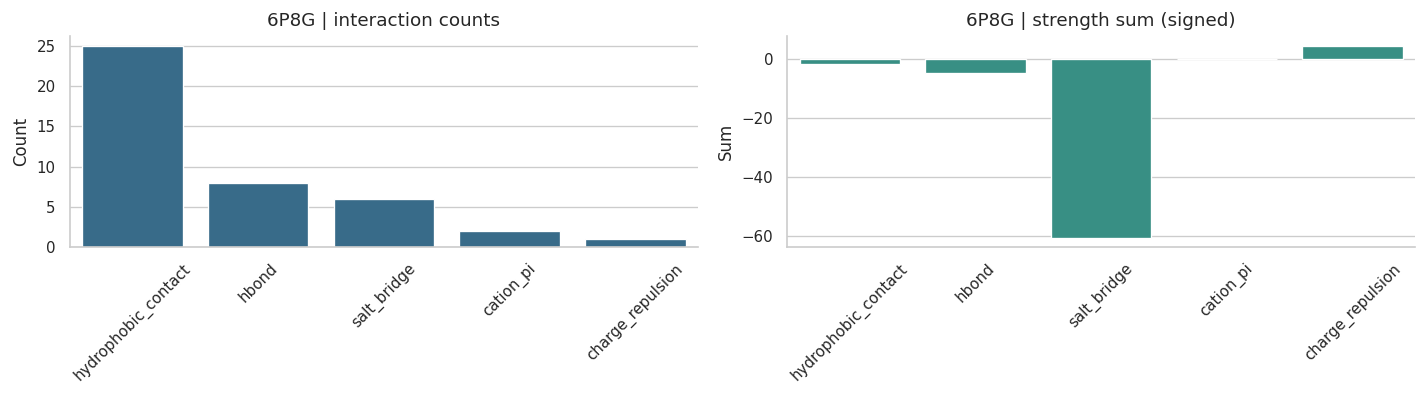

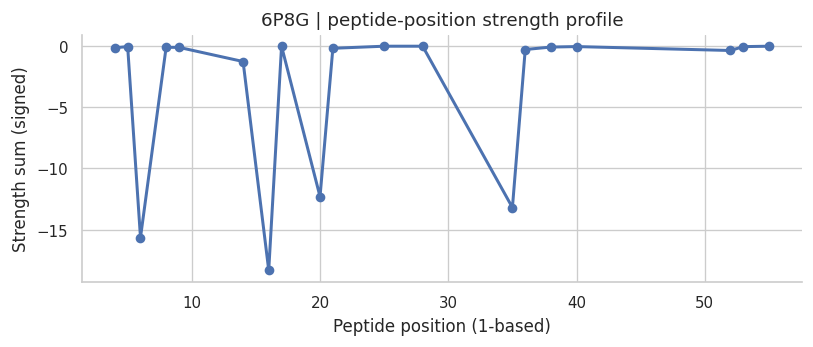

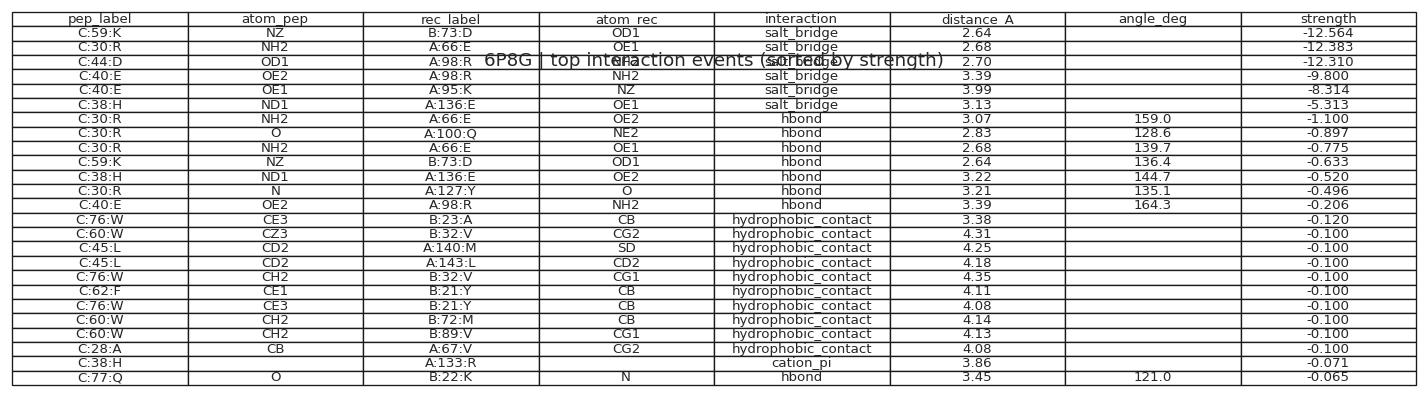

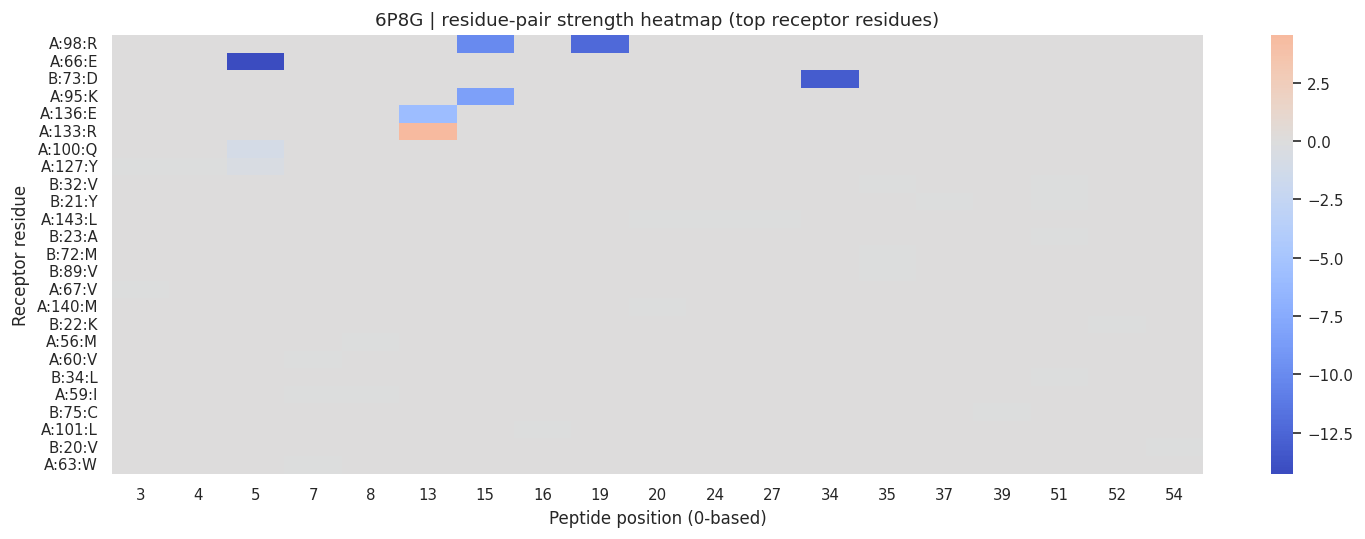

pdb_id pep_chain  pep_index  pep_resseq pep_icode pep_resn pep_aa rec_chain  \
0   6P8E         C          2          26                PRO      P         A   
1   6P8E         C          4          28                ALA      A         A   
2   6P8E         C          5          29                CYS      C         A   
3   6P8E         C          5          29                CYS      C         A   
4   6P8E         C          6          30                ARG      R         A   

   rec_resseq rec_icode  ...      pep_x      pep_y      pep_z      rec_x  \
0         127            ...  54.389000  16.051001  45.660000  50.575001   
1         127            ...  49.916000  16.764999  43.787998  50.575001   
2         126            ...  53.504002  19.650999  46.849998  54.324001   
3         127            ...  53.504002  19.650999  46.849998  50.168999   
4         100            ...  49.301998  24.493000  43.077000  46.709000   

       rec_y      rec_z  pep_label  rec_label  complex  \
0  16.983000  47.591999     C:26:P    A:127:Y     6P8E   
1  16.983000  47.591999     C:28:A    A:127:Y     6P8E   
2  21.030001  50.387001     C:29:C    A:126:I     6P8E   
3  18.291000  47.495998     C:29:C    A:127:Y     6P8E   
4  24.878000  44.353001     C:30:R    A:100:Q     6P8E   

                                         peptide_seq  
0  FKPSACRNLFGPVDHEELTRDLEKHCRDMEEASQRKWNFDFQNHKP...  
1  FKPSACRNLFGPVDHEELTRDLEKHCRDMEEASQRKWNFDFQNHKP...  
2  FKPSACRNLFGPVDHEELTRDLEKHCRDMEEASQRKWNFDFQNHKP...  
3  FKPSACRNLFGPVDHEELTRDLEKHCRDMEEASQRKWNFDFQNHKP...  
4  FKPSACRNLFGPVDHEELTRDLEKHCRDMEEASQRKWNFDFQNHKP...  

[5 rows x 28 columns]

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from Bio.PDB import PDBParser

from peptide_screening.interaction_analysis import analyze_interface_interactions, summarize_interactions
from peptide_screening.structure import chain_sequence

parser = PDBParser(QUIET=True)

analysis_cfg = {
    "receptor_chains": ("A", "B"),
    "peptide_chain": "C",
    "neighbor_cutoff_A": float(cfg["structure"]["pocket_cutoff_A"]),
    "dielectric": 10.0,
}

all_events = []

for pdb_path in tqdm(pdb_paths, desc="Interaction analysis", unit="pdb"):
    df_ev = analyze_interface_interactions(
        pdb_path,
        receptor_chains=analysis_cfg["receptor_chains"],
        peptide_chain=analysis_cfg["peptide_chain"],
        neighbor_cutoff_A=analysis_cfg["neighbor_cutoff_A"],
        dielectric=analysis_cfg["dielectric"],
    )

    try:
        model = next(parser.get_structure("x", str(pdb_path)).get_models())
        pep_seq = chain_sequence(model[analysis_cfg["peptide_chain"]])
    except Exception:
        pep_seq = ""

    df_ev["complex"] = pdb_path.stem
    df_ev["peptide_seq"] = pep_seq
    all_events.append(df_ev)

    out_dir = analysis_dir / pdb_path.stem
    out_dir.mkdir(parents=True, exist_ok=True)
    df_ev.to_csv(out_dir / "interaction_events.csv", index=False)

    sums = summarize_interactions(df_ev)
    for k, dfk in sums.items():
        dfk.to_csv(out_dir / f"summary_{k}.csv", index=False)

    by_type = sums["by_type"].copy()
    if not by_type.empty:
        fig, axes = plt.subplots(1, 2, figsize=(12.0, 3.4))
        sns.barplot(data=by_type, x="interaction", y="n", ax=axes[0], color="#2a6f97")
        axes[0].set_title(f"{pdb_path.stem} | interaction counts")
        axes[0].set_xlabel("")
        axes[0].set_ylabel("Count")
        axes[0].tick_params(axis="x", rotation=45)

        sns.barplot(data=by_type, x="interaction", y="strength_sum", ax=axes[1], color="#2a9d8f")
        axes[1].set_title(f"{pdb_path.stem} | strength sum (signed)")
        axes[1].set_xlabel("")
        axes[1].set_ylabel("Sum")
        axes[1].tick_params(axis="x", rotation=45)

        savefig(fig, fig_dir / f"complex_{pdb_path.stem}_interaction_type_summary.png")
        plt.show()

    if not df_ev.empty:
        df_ev["strength"] = pd.to_numeric(df_ev["strength"], errors="coerce")

        pos = df_ev.groupby("pep_index", as_index=False)["strength"].sum().sort_values("pep_index")
        fig, ax = plt.subplots(figsize=(7.0, 3.0))
        ax.plot(pos["pep_index"] + 1, pos["strength"], marker="o", lw=1.8)
        ax.set_title(f"{pdb_path.stem} | peptide-position strength profile")
        ax.set_xlabel("Peptide position (1-based)")
        ax.set_ylabel("Strength sum (signed)")
        savefig(fig, fig_dir / f"complex_{pdb_path.stem}_pep_position_profile.png")
        plt.show()

        top = (
            df_ev.sort_values("strength", ascending=True)
            .head(25)[["pep_label", "atom_pep", "rec_label", "atom_rec", "interaction", "distance_A", "angle_deg", "strength"]]
            .copy()
        )
        top["atom_pep"] = top["atom_pep"].fillna("").astype(str)
        top["atom_rec"] = top["atom_rec"].fillna("").astype(str)
        top["distance_A"] = pd.to_numeric(top["distance_A"], errors="coerce").map(lambda x: f"{x:.2f}" if pd.notnull(x) else "")
        top["angle_deg"] = pd.to_numeric(top["angle_deg"], errors="coerce").map(lambda x: f"{x:.1f}" if pd.notnull(x) else "")
        top["strength"] = pd.to_numeric(top["strength"], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notnull(x) else "")

        fig, ax = plt.subplots(figsize=(12.0, 4.2))
        ax.axis("off")
        tbl = ax.table(
            cellText=top.values.tolist(),
            colLabels=top.columns.tolist(),
            loc="center",
            cellLoc="center",
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1.0, 1.2)
        ax.set_title(f"{pdb_path.stem} | top interaction events (sorted by strength)", pad=10)
        savefig(fig, fig_dir / f"complex_{pdb_path.stem}_top_interactions_table.png")
        plt.show()

        rec_rank = (
            df_ev.groupby("rec_label")["strength"].sum().abs().sort_values(ascending=False).head(25).index.tolist()
        )
        heat = (
            df_ev[df_ev["rec_label"].isin(rec_rank)]
            .pivot_table(index="pep_index", columns="rec_label", values="strength", aggfunc="sum", fill_value=0.0)
            .sort_index(axis=0)
        )
        heat = heat.loc[:, rec_rank]

        fig, ax = plt.subplots(figsize=(12.5, 4.6))
        sns.heatmap(heat.T, cmap="coolwarm", center=0.0, ax=ax)
        ax.set_title(f"{pdb_path.stem} | residue-pair strength heatmap (top receptor residues)")
        ax.set_xlabel("Peptide position (0-based)")
        ax.set_ylabel("Receptor residue")
        savefig(fig, fig_dir / f"complex_{pdb_path.stem}_residue_pair_heatmap.png")
        plt.show()

df_events = pd.concat(all_events, ignore_index=True) if all_events else pd.DataFrame()
df_events.to_csv(analysis_dir / "all_complex_interaction_events.csv", index=False)
df_events.head()


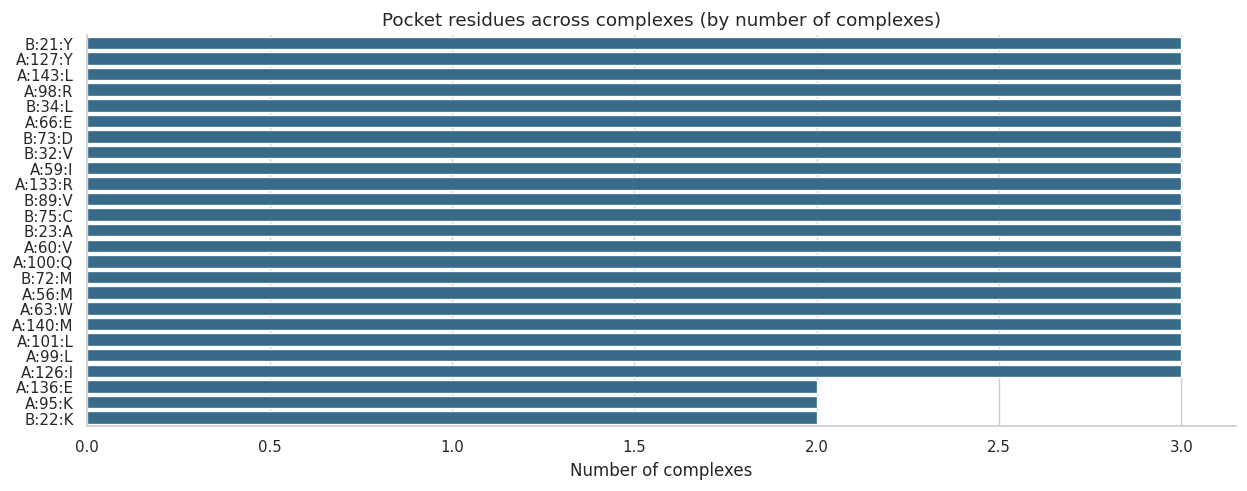

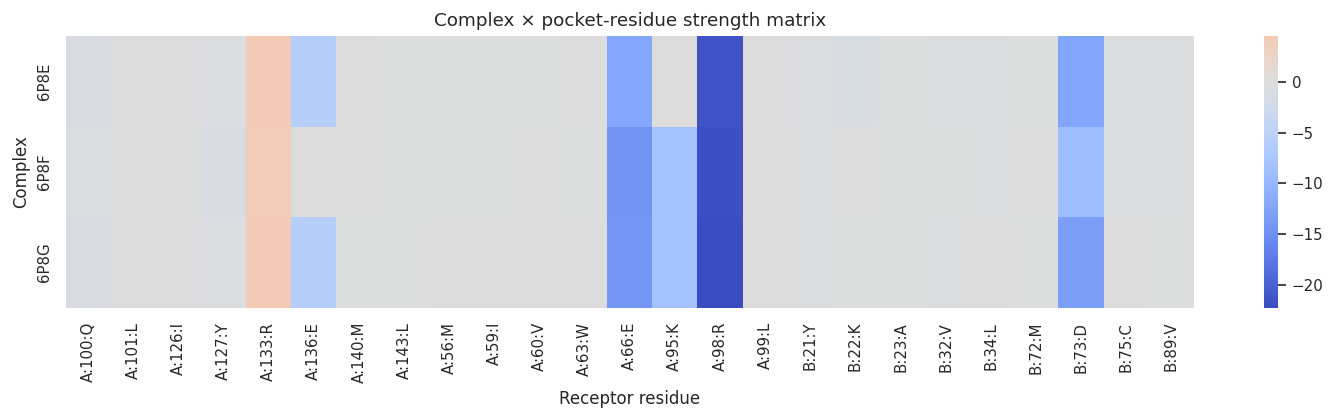

/media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/Food Chemistry/peptide_screening/viz.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


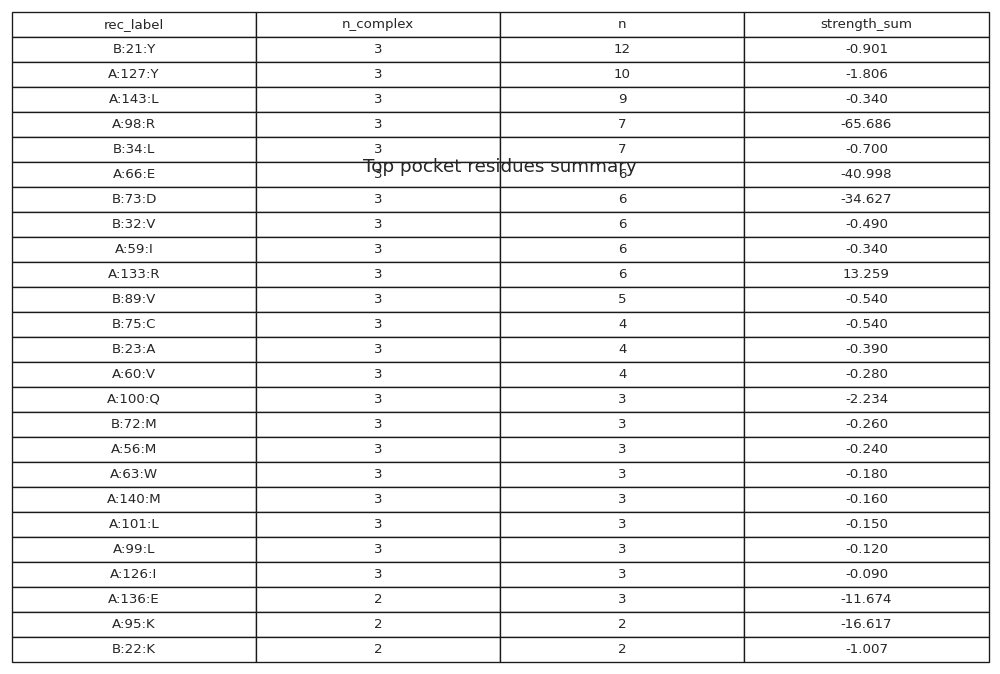

rec_label rec_chain  rec_resseq rec_aa   n  n_complex  strength_sum
0    B:21:Y         B          21      Y  12          3     -0.900535
1   A:127:Y         A         127      Y  10          3     -1.806305
2   A:143:L         A         143      L   9          3     -0.340000
3    A:98:R         A          98      R   7          3    -65.686123
4    B:34:L         B          34      L   7          3     -0.700000
5    A:66:E         A          66      E   6          3    -40.997796
6    B:73:D         B          73      D   6          3    -34.626590
7    B:32:V         B          32      V   6          3     -0.490000
8    A:59:I         A          59      I   6          3     -0.340000
9   A:133:R         A         133      R   6          3     13.258576

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if df_events.empty:
    print("df_events is empty; run the interaction-analysis cell first.")
else:
    df_events["strength"] = pd.to_numeric(df_events["strength"], errors="coerce")

    pocket = (
        df_events.groupby(["rec_label", "rec_chain", "rec_resseq", "rec_aa"], as_index=False)
        .agg(
            n=("interaction", "size"),
            n_complex=("complex", "nunique"),
            strength_sum=("strength", "sum"),
        )
        .sort_values(["n_complex", "n", "strength_sum"], ascending=[False, False, True])
        .reset_index(drop=True)
    )
    pocket.to_csv(analysis_dir / "pocket_residue_summary.csv", index=False)

    top_pocket = pocket.head(25).copy()
    fig, ax = plt.subplots(figsize=(10.5, 4.2))
    sns.barplot(data=top_pocket, y="rec_label", x="n_complex", ax=ax, color="#2a6f97")
    ax.set_title("Pocket residues across complexes (by number of complexes)")
    ax.set_xlabel("Number of complexes")
    ax.set_ylabel("")
    savefig(fig, fig_dir / "pocket_residues_by_complex_count.png")
    plt.show()

    top_res = top_pocket["rec_label"].tolist()
    mat = (
        df_events[df_events["rec_label"].isin(top_res)]
        .groupby(["complex", "rec_label"], as_index=False)["strength"].sum()
        .pivot(index="complex", columns="rec_label", values="strength")
        .fillna(0.0)
    )

    fig, ax = plt.subplots(figsize=(12.5, max(3.6, 0.35 * len(mat))))
    sns.heatmap(mat, cmap="coolwarm", center=0.0, ax=ax)
    ax.set_title("Complex × pocket-residue strength matrix")
    ax.set_xlabel("Receptor residue")
    ax.set_ylabel("Complex")
    savefig(fig, fig_dir / "complex_vs_pocket_residue_heatmap.png")
    plt.show()

    show = top_pocket[["rec_label", "n_complex", "n", "strength_sum"]].copy()
    show["strength_sum"] = pd.to_numeric(show["strength_sum"], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notnull(x) else "")
    fig, ax = plt.subplots(figsize=(10.5, 3.2))
    ax.axis("off")
    table = ax.table(
        cellText=show.values.tolist(),
        colLabels=show.columns.tolist(),
        loc="center",
        cellLoc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.0, 1.25)
    ax.set_title("Top pocket residues summary", pad=10)
    savefig(fig, fig_dir / "pocket_residue_summary_table.png")
    plt.show()

pocket.head(10) if "pocket" in locals() else None


In [28]:
from pathlib import Path
import base64
import pandas as pd

try:
    import py3Dmol
except ModuleNotFoundError:
    py3Dmol = None
    print("py3Dmol is not installed. Install with: pip install py3Dmol")

if py3Dmol is None or df_events.empty:
    print("3D visualization is skipped.")
else:
    complex_id = str(df_events["complex"].iloc[0])
    pdb_path = pdb_by_id.get(complex_id)
    if pdb_path is None:
        raise RuntimeError(f"Cannot find PDB path for complex_id={complex_id}")

    df_ev = df_events[df_events["complex"] == complex_id].copy()
    df_ev["strength"] = pd.to_numeric(df_ev["strength"], errors="coerce")
    df_lines = df_ev.dropna(subset=["pep_x", "pep_y", "pep_z", "rec_x", "rec_y", "rec_z"]).copy()
    df_lines["abs_strength"] = df_lines["strength"].abs()
    df_lines = df_lines.sort_values("abs_strength", ascending=False).head(80)

    pdb_str = Path(pdb_path).read_text(encoding="utf-8")
    v = py3Dmol.view(width=950, height=560)
    v.addModel(pdb_str, "pdb")
    v.setBackgroundColor("white")
    v.setStyle({"chain": "A"}, {"cartoon": {"color": "#1f77b4"}})
    v.setStyle({"chain": "B"}, {"cartoon": {"color": "#2a9d8f"}})
    v.setStyle({"chain": "C"}, {"stick": {"color": "#d62828"}})

    color_map = {
        "hbond": "#1d3557",
        "salt_bridge": "#e63946",
        "charge_repulsion": "#ffb703",
        "hydrophobic_contact": "#6c757d",
        "pi_pi_parallel": "#6a4c93",
        "pi_pi_t": "#6a4c93",
        "pi_pi_other": "#6a4c93",
        "cation_pi": "#3a86ff",
    }

    for _, r in df_lines.iterrows():
        col = color_map.get(str(r["interaction"]), "#343a40")
        v.addLine(
            {
                "start": {"x": float(r["pep_x"]), "y": float(r["pep_y"]), "z": float(r["pep_z"])},
                "end": {"x": float(r["rec_x"]), "y": float(r["rec_y"]), "z": float(r["rec_z"])},
                "color": col,
            }
        )

    v.zoomTo()
    v.show()

    out_png = fig_dir / f"complex_{complex_id}_3d_interactions.png"
    try:
        png = v.png()
        if isinstance(png, bytes):
            out_png.write_bytes(png)
            print("saved:", out_png)
        elif isinstance(png, str):
            out_png.write_bytes(base64.b64decode(png))
            print("saved:", out_png)
        else:
            print("png export returned unsupported type:", type(png))
    except Exception as e:
        print("png export unavailable:", e)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

png export returned unsupported type: <class 'NoneType'>
